In [1]:
library(Seurat)
library(ggplot2)
library(UCell)
library(patchwork)
library(tidyr)
library(dplyr)
library(RColorBrewer)
library(GeneNMF)
library(rhdf5)
library(SingleCellExperiment)
library(SummarizedExperiment)
library(GenomicRanges)
library(BiocGenerics)
library(generics)
library(Matrix)
library(scater)
library(data.table)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘matrixStats’


The following object is masked from ‘package:dplyr’:

    count



Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantile

In [2]:
do_download <- FALSE

ddir <- "input"
data.path <- sprintf("%s/Tumor_combination_LY_CG.rds", ddir)

if (do_download) {
  dir.create(ddir)
  options(timeout = 3000)
  download.file("https://figshare.com/ndownloader/files/47742634", destfile = data.path)
}

seu <- readRDS(data.path)

In [3]:
Make_unique <- function(arr) {
  dep_arr <- list()
  dep_idx <- which(duplicated(arr))
  for (idx in dep_idx) {
    item <- arr[idx]
    if (!(item %in% attr(dep_arr, "names"))) {
      dep_arr[item] <- 1
    }
    count <- dep_arr[[item]]
    arr[idx] <- paste0(arr[idx], ".", count)
    dep_arr[[item]] <- dep_arr[[item]] + 1
  }
  return(arr)
}

Load_h5adsc_to_SCE <- function(scpath, raw = TRUE) {
  scmat <- h5read(scpath, "/")
  if (("Raw" %in% attr(scmat$layers, "names")) && raw) {
    cat("** Using raw data...\n")
    if (class(scmat$layers$Raw)[[1]] == "list") {
      cat("** Raw data is a sparse matrix...\n")
      dat <- sparseMatrix(
        i = scmat$layers$Raw$indices[] + 1,
        p = scmat$layers$Raw$indptr[],
        x = as.numeric(scmat$layers$Raw$data[]),
        repr = "C"
      )
    } else {
      cat("** Raw data is a dense matrix...\n")
      dat <- as(scmat$layers$Raw, "dgCMatrix")
    }
    h5ad.var <- scmat$var
  } else {
    cat("** Using processed data...\n")
    X <- scmat$X
    dat <- sparseMatrix(
      i = X$indices[] + 1,
      p = X$indptr[],
      x = as.numeric(X$data[]),
      repr = "C"
    )
    h5ad.var <- scmat$var
  }
  cat("** Core data loaded...\n")
  # generate factors using categories
  var <- list()
  if ("__categories" %in% attr(h5ad.var, "names")) { # old anndata
    for (name in attr(h5ad.var[["__categories"]], "names")) {
      if (length(h5ad.var[[name]]) >= length(h5ad.var[["__categories"]][[name]])) {
        var[[name]] <- factor(h5ad.var[[name]], labels = h5ad.var[["__categories"]][[name]])
      }
    }
  } else {
    for (name in attr(h5ad.var, "names")) {
      if (name != "_index") {
        if (class(var[[name]]) == "list") {
          var[[name]] <- factor(h5ad.var[[name]]$codes,
            labels = h5ad.var[[name]]$categories
          )
        } else {
          var[[name]] <- h5ad.var[[name]]
        }
      } else {
        var[[name]] <- h5ad.var[[name]]
      }
    }
  }
  cat("** Var loaded...\n")
  h5ad.obs <- scmat$obs
  obs <- list()
  if ("__categories" %in% attr(h5ad.obs, "names")) { # old anndata
    for (name in attr(h5ad.obs[["__categories"]], "names")) {
      if (length(h5ad.obs[[name]]) >= length(h5ad.obs[["__categories"]][[name]])) {
        obs[[name]] <- factor(h5ad.obs[[name]], labels = h5ad.obs[["__categories"]][[name]])
      }
    }
  } else { # new anndata
    for (name in attr(h5ad.obs, "names")) {
      if (name != "_index") {
        if (class(h5ad.obs[[name]]) == "list") {
          obs[[name]] <- factor(h5ad.obs[[name]]$codes,
            labels = h5ad.obs[[name]]$categories
          )
        } else {
          obs[[name]] <- h5ad.obs[[name]]
        }
      } else {
        obs[[name]] <- h5ad.obs[[name]]
      }
    }
  }
  # some datasets uses barcodes instead of `_index`
  if (!("_index" %in% attr(h5ad.obs, "names"))) {
    obs$`_index` <- obs$`barcodes`
  }
  obs$`_index` <- Make_unique(obs$`_index`)
  obs_use <- data.frame(
    annotation = obs$annotation,
    batch = obs$batch,
    treat = obs$treat,
    cnv_status = obs$cnv_status,
    cnv_score = obs$cnv_score,
    row.names = as.character(obs$`_index`)
  )
  cat("** Obs loaded...\n")
  dims <- c(length(h5ad.var[["_index"]]), length(obs$`_index`))
  dat@Dim <- dims
  dat@Dimnames <- list(
    as.character(h5ad.var[["_index"]]),
    as.character(obs$`_index`)
  )
  cat("** Dims loaded...\n")

  sce <- SingleCellExperiment(
    assays = list(counts = dat),
    rowData = DataFrame(data.frame(var[['_index']])),
    colData = DataFrame(data.frame(obs_use))
  )
  cat("** SCE constructed...\n")

  umap <- as.data.frame(t(scmat$obsm$X_umap))
  colnames(umap) <- c('UMAP-1', 'UMAP-2')
  rownames(umap) <- colnames(sce)
  reducedDim(sce, 'UMAP', withDimnames=TRUE) <- umap
  cat("** UMAP loaded...\n")
  return(sce)
}

In [4]:
sce <- Load_h5adsc_to_SCE("adata-epi-total.h5ad", raw = TRUE)

** Using processed data...
** Core data loaded...
** Var loaded...
** Obs loaded...
** Dims loaded...
** SCE constructed...
** UMAP loaded...


In [9]:
sce

class: SingleCellExperiment 
dim: 39735 38680 
metadata(0):
assays(1): counts
rownames(39735): TNFRSF4 TNFRSF18 ... CR381653.1 ITGB2-AS1
rowData names(1): var..._index...
colnames(38680): AAACCCAAGACCAAGC-1-1T AAACCCATCACTTTGT-1-1T ...
  TTTGTCAGTCATCCCT-1-22T TTTGTCATCAATCACG-1-22T
colData names(5): annotation batch treat cnv_status cnv_score
reducedDimNames(1): UMAP
mainExpName: NULL
altExpNames(0):

In [5]:
seu <- SeuratObject::as.Seurat(x = sce, counts = "counts", data = "counts")

Warning message:
“`PackageCheck()` was deprecated in SeuratObject 5.0.0.
ℹ Please use `rlang::check_installed()` instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”


Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“The `slot` argument of `SetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from UMAP- to UMAP_”


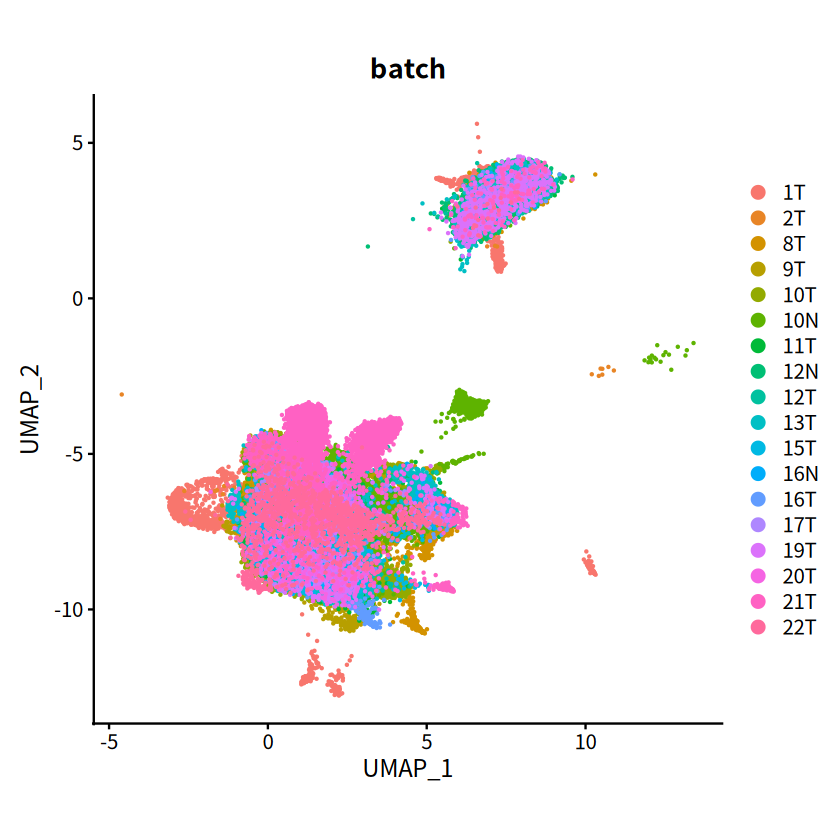

In [8]:
DimPlot(seu, group.by="batch") + theme(aspect.ratio = 1)

In [6]:
seu.list.batch <- SplitObject(seu, split.by = "batch")
seu.list.batch 

$`1T`
An object of class Seurat 
39735 features across 2834 samples within 1 assay 
Active assay: originalexp (39735 features, 0 variable features)
 2 layers present: counts, data
 1 dimensional reduction calculated: UMAP

$`2T`
An object of class Seurat 
39735 features across 2268 samples within 1 assay 
Active assay: originalexp (39735 features, 0 variable features)
 2 layers present: counts, data
 1 dimensional reduction calculated: UMAP

$`8T`
An object of class Seurat 
39735 features across 6074 samples within 1 assay 
Active assay: originalexp (39735 features, 0 variable features)
 2 layers present: counts, data
 1 dimensional reduction calculated: UMAP

$`9T`
An object of class Seurat 
39735 features across 1182 samples within 1 assay 
Active assay: originalexp (39735 features, 0 variable features)
 2 layers present: counts, data
 1 dimensional reduction calculated: UMAP

$`10T`
An object of class Seurat 
39735 features across 6881 samples within 1 assay 
Active assay: originale

In [126]:
attr(seu.list.batch, 'names')

[1] "1T"  "2T"  "8T"  "9T"  "10T" "10N" "11T" "12N" "12T" "13T" "15T" "16N"
[13] "16T" "17T" "19T" "20T" "21T" "22T"

In [7]:
seu.Total <- list(  
                 `11T` = seu.list.batch$`11T`,
                 `12T` = seu.list.batch$`12T`,
                 `13T` = seu.list.batch$`13T`,
                 `16T` = seu.list.batch$`16T`,
                 `19T` = seu.list.batch$`19T`,
                 `1T` = seu.list.batch$`1T`,
                 `2T` = seu.list.batch$`2T`,
                 `8T` = seu.list.batch$`8T`,
                 `9T` = seu.list.batch$`9T`,
                 `15T` = seu.list.batch$`15T`,
                 `17T` = seu.list.batch$`17T`,
                  `10T` = seu.list.batch$`10T`,
                 `20T` = seu.list.batch$`20T`,
                 `21T` = seu.list.batch$`21T`,
                 `22T` = seu.list.batch$`22T`
                 )

In [8]:
seu.After <- list(  
                 `11T` = seu.list.batch$`11T`,
                 `12T` = seu.list.batch$`12T`,
                 `13T` = seu.list.batch$`13T`,
                 `16T` = seu.list.batch$`16T`,
                 `19T` = seu.list.batch$`19T`
                 )

In [129]:
seu.Better <- list(  
                 `13T` = seu.list.batch$`13T`,
                 `19T` = seu.list.batch$`19T`
                 )

In [130]:
seu.Worse <- list(  
                 `11T` = seu.list.batch$`11T`,
                 `12T` = seu.list.batch$`12T`,
                 `16T` = seu.list.batch$`16T`
                 )

In [132]:
seu.WOtreat <- list(
                 `10T` = seu.list.batch$`10T`,
                 `20T` = seu.list.batch$`20T`,
                 `21T` = seu.list.batch$`21T`,
                 `22T` = seu.list.batch$`22T`
                 )

In [7]:
seu.Before <- list(  `1T` = seu.list.batch$`1T`,
                 `2T` = seu.list.batch$`2T`,
                 `8T` = seu.list.batch$`8T`,
                 `9T` = seu.list.batch$`9T`,
                 `15T` = seu.list.batch$`15T`,
                 `17T` = seu.list.batch$`17T`
                 )

Dropped 1 empty meta-programs



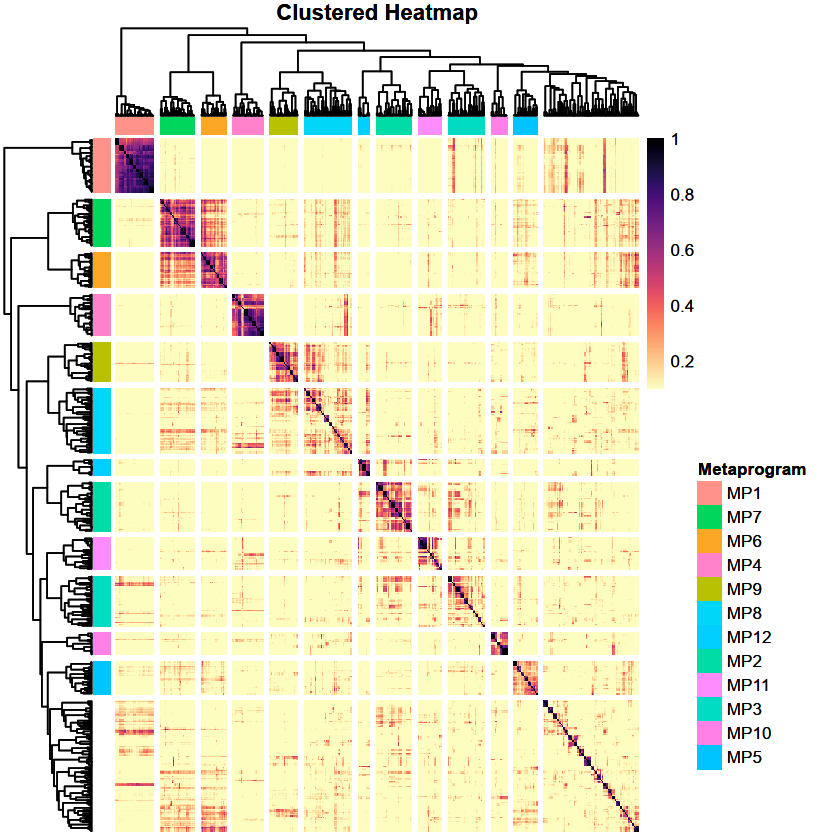

In [ ]:
geneNMF.programs.Total <- multiNMF(seu.Total, assay="originalexp", k=4:9, min.exp = 0.05)
geneNMF.metaprograms.Total <- getMetaPrograms(geneNMF.programs.Total,
                                        metric = "cosine",
                                        weight.explained = 0.8,
                                        nMP=14,
                                        min.confidence = 0.7
                                        )
ph <- plotMetaPrograms(geneNMF.metaprograms.Total,
                       similarity.cutoff = c(0.1,1))
ph

In [ ]:
svg(filename = "figures/Before-After-GeneSet.svg",width = 7,height = 9)
ph
dev.off()

pdf 
  2

In [38]:
# category含义为所选数据库 C5为GO C2为kegg
top_p.Total <- lapply(geneNMF.metaprograms.Total$metaprograms.genes, function(program) {
  runGSEA(program, universe=rownames(seu), category = "C5")
})

ERROR: Error: Function 'runGSEA' requires the 'fgsea' and 'msigdbr' packages.
            Please install them.


In [ ]:
geneNMF.metaprograms.Total$metaprograms.genes

In [18]:
geneNMF.metaprograms.Total$metaprograms.genes

$MP1
 [1] "ACTA2"    "TAGLN"    "TPM2"     "MYLK"     "MYL9"     "ECRG4"   
 [7] "CXCL14"   "CNN1"     "MYH11"    "KRT14"    "A2M"      "PPP1R14A"
[13] "SPARCL1"  "DKK3"     "ACTG2"    "MIR205HG" "MATN2"    "COL17A1" 
[19] "KRT17"    "POSTN"    "TP63"     "TNS4"     "SNCG"     "LTBP2"   
[25] "TSHZ2"    "SPARC"    "HTRA1"    "CAV1"    

$MP2
 [1] "KRT15"   "KRT23"   "LTF"     "CCL28"   "GABRP"   "LCN2"    "SLPI"   
 [8] "CRABP1"  "MMP7"    "S100A9"  "SCGB2A2" "RARRES1" "SAA2"    "PPP1R1B"
[15] "NDRG2"   "KRT14"   "JUN"    

$MP3
[1] "CD74"     "HLA-DRB1" "HLA-DRA"  "HLA-DPA1"

$MP4
 [1] "UBE2C"  "CENPF"  "PTTG1"  "TPX2"   "MAD2L1" "TOP2A"  "MKI67"  "TK1"   
 [9] "BIRC5"  "STMN1"  "MYBL2"  "TYMS"   "RRM2"   "CCNB1"  "HMGB2"  "ZWINT" 
[17] "UBE2T"  "CKS1B"  "LMNB1"  "ANP32E" "CENPN"  "ECT2"   "SMC4"  

$MP5
 [1] "NEAT1"     "MACF1"     "FLNB"      "PLEC"      "KCNQ1OT1"  "FTX"      
 [7] "FLNA"      "JUN"       "CCNL1"     "PPP1R15A"  "TRPS1"     "RNF213"   
[13] "RRBP1"     "NORAD"     "FOSB"      "LINC00472" "TRIB1"     "MCL1"     
[19] "MTATP6P1"  "CLK1"      "EPPK1"     "CDH1"      "HSPH1"     "PRLR"     
[25] "KAT6B"     "SPTBN1"    "PARP14"    "NF1"       "MIDEAS"    "ITPR2"    
[31] "VCL"       "LRIG1"     "PRKDC"     "ETNK1"     "ADAM17"    "LDLR"     

$MP6
 [1] "NR4A1"    "ATF3"     "FOSB"     "PPP1R15A" "RASD1"    "BAG3"    
 [7] "ZFP36"    "HSPA6"    "DUSP1"    "EGR1"     "RND1"     "KLF6"    
[13] "TRIB1"    "JUN"      "DNAJB1"   "BTG2"     "IER2"     "FOS"     
[19] "IER5"     "JUNB"     "CSRNP1"   "HSPA1B"   "MAFF"     "DNAJB4"  
[25] "GADD45B"  "ANKRD37"  "ELF3"     "HSPA1A"   "NR4A2"   

$MP7
 [1] "FOS"      "EGR1"     "JUN"      "IER2"     "DUSP1"    "JUNB"    
 [7] "FOSB"     "ZFP36"    "DNAJB1"   "GADD45B"  "HES1"     "PPP1R15A"
[13] "CCNL1"    "RHOB"     "MYC"      "HSPA1B"  

$MP8
 [1] "TFF1"   "TFF3"   "DNAJB1" "IER2"   "ZFP36"  "JUNB"   "FOS"    "JUN"   
 [9] "CRABP2" "HSPA1A"

$MP9
 [1] "AGR2"     "ANKRD30A" "TCIM"     "STC2"     "TFF1"     "TFF3"    
 [7] "AGR3"     "SYTL2"    "PLAT"     "BATF"     "AFF3"     "SCUBE2"  
[13] "ERBB4"    "AZGP1"    "FBP1"     "ESR1"     "CAPN8"    "DCDC2"   
[19] "INPP4B"   "SLC40A1"  "EFHD1"    "PREX1"    "LRP2"     "MAGED2"  
[25] "DNAJC12"  "GALNT6"   "XBP1"     "MGP"      "SPDEF"   

$MP10
[1] "KRT17" "TAGLN" "MYL9"  "MMP7" 

$MP11
[1] "MUCL1"    "PIP"      "ALDH3B2"  "SERPINA1" "NUDT8"   

$MP12
[1] "S100A8" "S100A9"

$MP13
[1] "SCGB2A2" "SCGB1D2"

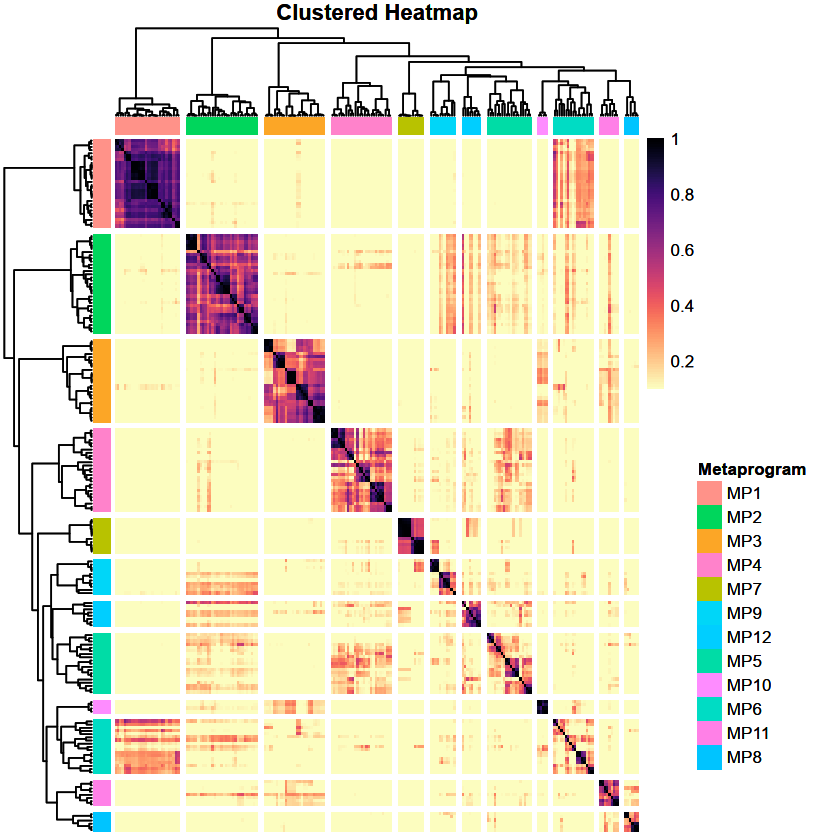

In [24]:
geneNMF.programs.After <- multiNMF(seu.After, assay="originalexp", k=4:9, min.exp = 0.05)
geneNMF.metaprograms.After <- getMetaPrograms(geneNMF.programs.After,
                                        metric = "cosine",
                                        weight.explained = 0.8,
                                        nMP=12,
                                        min.confidence = 0.7
                                        )
ph <- plotMetaPrograms(geneNMF.metaprograms.After,
                       similarity.cutoff = c(0.1,1))
ph

In [26]:
svg(filename = "figures/After-GeneSet.svg",width = 7,height = 9)
ph
dev.off()

pdf 
  2

In [23]:
# category含义为所选数据库 C5为GO C2为kegg
top_p.After <- lapply(geneNMF.metaprograms.After$metaprograms.genes, function(program) {
  runGSEA(program, universe=rownames(seu), category = "C5")
})

In [24]:
for (i in 1:length(top_p.After)) {
  fwrite(top_p.After[[i]], file = paste0("figures/AfterGeneSet/TableS6-MP", i, ".csv"), col.names = T, append = F, quote = F)
}

In [25]:
lapply(geneNMF.metaprograms.After$metaprograms.genes, head)

$MP1
[1] "ACTA2"  "TAGLN"  "TPM2"   "ECRG4"  "CXCL14" "MYLK"  

$MP2
[1] "EGR1"  "FOS"   "JUN"   "IER2"  "JUNB"  "ZFP36"

$MP3
[1] "KRT15" "MMP7"  "GABRP" "CCL28" "SLPI"  "LTF"  

$MP4
[1] "TFF1"     "ANKRD30A" "STC2"     "TFF3"     "SCUBE2"   "AGR2"    

$MP5
[1] "TFF1"      "TCIM"      "MIDEAS"    "GPRC5A"    "ZFP36"     "RAB11FIP1"

$MP6
[1] "COL14A1" "TAGLN"   "MYLK"    "EGR1"    "APOE"    "MYL9"   

$MP7
[1] "MUCL1"    "SERPINA1" "PIP"      "ALDH3B2"  "HMGCS2"   "NUDT8"   

$MP8
[1] "HLA-DRA"  "CD74"     "HLA-DRB1" "WARS1"    "HLA-DPA1" "HLA-DQB1"

$MP9
[1] "PIP"      "SCGB1D2"  "SCGB2A2"  "SCGB1B2P" "JUN"      "DUSP1"   

$MP10
[1] "SNORC"   "SLC12A2" "NCALD"   "S100A1"  "MELTF"   "PPP1R1B"

$MP11
[1] "CALML5" "S100P"  "CRABP1" "CDKN2A" "IMPA2"  "STMN1" 

$MP12
[1] "C2CD4B"     "ARRDC4"     "DHRS2"      "AC093001.1" "DNAJA4"    
[6] "TFPI"

In [26]:
geneNMF.metaprograms.After$metaprograms.genes

$MP1
 [1] "ACTA2"    "TAGLN"    "TPM2"     "ECRG4"    "CXCL14"   "MYLK"    
 [7] "MYL9"     "CNN1"     "MYH11"    "SYT8"     "KRT14"    "ACTG2"   
[13] "PPP1R14A" "DKK3"     "MATN2"    "POSTN"    "APOE"     "COL17A1" 
[19] "A2M"      "SPARCL1"  "MIR205HG" "TGFB1I1"  "KCNMB1"   "KRT17"   
[25] "TP63"     "TNS4"     "SNCG"     "PDLIM7"   "LMOD1"    "MSRB3"   
[31] "LTBP2"    "OXTR"     "MME"      "TSHZ2"    "PDGFA"    "CARMN"   
[37] "FGF1"     "ADAMTS5"  "EGR1"     "NEXN"     "IL17B"    "CD200"   
[43] "GAS1"     "LIMS2"   

$MP2
 [1] "EGR1"       "FOS"        "JUN"        "IER2"       "JUNB"      
 [6] "ZFP36"      "DUSP1"      "SOCS3"      "DNAJB1"     "FOSB"      
[11] "EGR2"       "CCNL1"      "DDIT3"      "HES1"       "GADD45B"   
[16] "SERTAD1"    "PPP1R15A"   "H2AX"       "MYC"        "KLF10"     
[21] "IER3"       "IRF1"       "SNHG12"     "CSRNP1"     "RHOB"      
[26] "MCL1"       "DNAJB4"     "AC011446.2" "CLK1"      

$MP3
 [1] "KRT15"   "MMP7"    "GABRP"   "CCL28"   "SLPI"    "LTF"     "KIT"    
 [8] "RARRES1" "KRT23"   "SNORC"   "ALDH1A3" "PIGR"    "LCN2"    "PROM1"  
[15] "KRT6B"   "SLC34A2" "CRABP1"  "KRT14"   "TTYH1"   "NDRG2"   "SAA2"   
[22] "JUN"     "KRT17"   "FOLR1"  

$MP4
 [1] "TFF1"      "ANKRD30A"  "STC2"      "TFF3"      "SCUBE2"    "AGR2"     
 [7] "PLAT"      "DCDC2"     "AFF3"      "AGR3"      "PDK4"      "AREG"     
[13] "TCIM"      "LRP2"      "SLC40A1"   "FBP1"      "AZGP1"     "C15orf48" 
[19] "ERBB4"     "SLC7A2"    "INPP4B"    "VSIG10L2"  "NEK10"     "BATF"     
[25] "GDF15"     "CITED1"    "ACADSB"    "LINC00993" "MGP"       "XBP1"     
[31] "DAPL1"     "VSIG2"     "UCP2"      "ZFP36"    

$MP5
 [1] "TFF1"      "TCIM"      "MIDEAS"    "GPRC5A"    "ZFP36"     "RAB11FIP1"
 [7] "DNAJB1"    "ISG15"     "JUNB"      "KIAA0040"  "SLC39A6"   "IER2"     
[13] "BATF"      "C15orf48"  "GADD45B"   "NR4A1"     "PIP"       "LURAP1L"  
[19] "CLDN4"     "AGR3"      "CD55"      "ELF3"      "IER3"      "CEBPD"    

$MP6
 [1] "COL14A1"  "TAGLN"    "MYLK"     "EGR1"     "APOE"     "MYL9"    
 [7] "MYH11"    "TPM2"     "SPARCL1"  "A2M"      "IL17RD"   "SEMA3C"  
[13] "LMOD1"    "MIR205HG" "COL17A1"  "SFRP2"   

$MP7
[1] "MUCL1"    "SERPINA1" "PIP"      "ALDH3B2"  "HMGCS2"   "NUDT8"   

$MP8
 [1] "HLA-DRA"  "CD74"     "HLA-DRB1" "WARS1"    "HLA-DPA1" "HLA-DQB1"
 [7] "PSMB9"    "PLAAT4"   "C1S"      "SOD2"     "TYMP"     "UBE2L6"  
[13] "IL32"    

$MP9
 [1] "PIP"      "SCGB1D2"  "SCGB2A2"  "SCGB1B2P" "JUN"      "DUSP1"   
 [7] "STC2"     "JUNB"     "ZFP36"    "FADS2"    "FOSB"     "AZGP1"   
[13] "CCNL1"    "ESR1"    

$MP10
 [1] "SNORC"      "SLC12A2"    "NCALD"      "S100A1"     "MELTF"     
 [6] "PPP1R1B"    "TESC"       "KCNN4"      "ACTR3B"     "PLA2R1"    
[11] "MRAS"       "PADI2"      "LTF"        "ZG16B"      "IGFBP7"    
[16] "CRABP1"     "ROCR"       "PDK3"       "SLPI"       "FOS"       
[21] "KRT15"      "PIP"        "CCDC71L"    "CCL28"      "TTYH1"     
[26] "NDRG2"      "FSCN1"      "FRZB"       "STAC2"      "IER2"      
[31] "ELF5"       "SFRP1"      "PDCD4"      "GABRP"      "PALMD"     
[36] "JUNB"       "LCN2"       "CBR3"       "JUN"        "PHLDA1"    
[41] "EGR2"       "SLC34A2"    "SPARCL1"    "CKB"        "CD44"      
[46] "AC007906.2" "MYBPC1"     "SOCS3"      "PROM1"      "PDGFA"     
[51] "SYNM"       "EGR1"       "INSIG1"     "FABP7"      "CALML5"    
[56] "VIM"        "ANO1"       "AC036108.2" "TPD52L1"    "NUDT8"     
[61] "FGFBP1"     "SAA2"       "PYGB"       "CRISPLD1"   "RCAN1"     
[66] "LMO4"       "TNS4"       "PIGR"       "DBI"        "DEPP1"     
[71] "ITM2A"      "SOD3"       "SCGB2A2"    "HTRA1"      "CAV1"      
[76] "EGLN3"      "S100A9"    

$MP11
 [1] "CALML5"   "S100P"    "CRABP1"   "CDKN2A"   "IMPA2"    "STMN1"   
 [7] "C20orf27" "KRT15"    "IER2"     "WARS1"    "PCNA"     "FADS2"   
[13] "PCSK1N"   "COTL1"    "CKS1B"    "CD74"     "H2AW"     "UNG"     
[19] "LY6D"     "PHGDH"    "HLA-DPA1" "S100A4"   "IL32"     "DNAJB1"  
[25] "TAP1"     "MCM7"     "PKP1"     "MGP"

In [27]:
geneNMF.metaprograms.After$metaprograms.metrics

,sampleCoverage,silhouette,meanSimilarity,numberGenes,numberPrograms
,<dbl>,<dbl>,<dbl>,<int>,<chr>
MP1,1.0,0.6768375,0.761,44,28
MP2,1.0,0.5313751,0.614,29,31
MP3,1.0,0.3840996,0.513,24,26
MP4,0.8,0.3033027,0.431,34,26
MP5,0.8,0.0760953,0.282,24,19
MP6,0.8,-0.0780157,0.228,16,17
MP7,0.4,0.6407959,0.696,6,11
MP8,0.4,0.4270210,0.507,13,6
MP9,0.4,0.2292498,0.382,14,11


In [8]:
geneNMF.programs.Before <- multiNMF(seu.Before, assay="originalexp", k=4:9, min.exp = 0.05)
geneNMF.metaprograms.Before <- getMetaPrograms(geneNMF.programs.Before,
                                        metric = "cosine",
                                        weight.explained = 0.8,
                                        nMP=8,
                                        min.confidence = 0.7
                                        )
ph <- plotMetaPrograms(geneNMF.metaprograms.Before,
                       similarity.cutoff = c(0.1,1))
ph

Warning message:
“The `slot` argument of `GetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”


In [29]:
svg(filename = "figures/Before-GeneSet.svg",width = 7,height = 6.5)
ph
dev.off()

pdf 
  2

In [25]:
geneNMF.metaprograms.Before$metaprograms.metrics

,sampleCoverage,silhouette,meanSimilarity,numberGenes,numberPrograms
,<dbl>,<dbl>,<dbl>,<int>,<chr>
MP1,0.8333333,0.5932834,0.623,25,20
MP2,0.8333333,0.5056520,0.547,10,29
MP3,0.6666667,0.4556638,0.517,18,26
MP4,0.6666667,0.1221669,0.279,6,34
MP5,0.5000000,0.4473735,0.519,17,13
MP6,0.5000000,0.3964869,0.466,10,13
MP7,0.5000000,0.1943631,0.324,2,26


In [26]:
top_p.Before <- lapply(geneNMF.metaprograms.Before$metaprograms.genes, function(program) {
  runGSEA(program, universe=rownames(seu), category = "C5")
})

In [27]:
for (i in 1:length(top_p.Before)) {
  fwrite(top_p.Before[[i]], file = paste0("figures/BeforeGeneSet/TableS6-MP", i, ".csv"), col.names = T, append = F, quote = F)
}

In [28]:
lapply(geneNMF.metaprograms.Before$metaprograms.genes, head)

$MP1
[1] "UBE2C" "CENPF" "TOP2A" "MKI67" "TPX2"  "TYMS" 

$MP2
[1] "TAGLN" "MYL9"  "ACTA2" "MYLK"  "TPM2"  "ACTG2"

$MP3
[1] "EGR1"  "ATF3"  "FOS"   "JUN"   "DUSP1" "IER2" 

$MP4
[1] "SCGB2A2" "SCGB1D2" "MGP"     "SNORC"   "NDRG2"   "SCGB3A1"

$MP5
[1] "AGR2"     "ANKRD30A" "STC2"     "TCIM"     "TFF1"     "TFF3"    

$MP6
[1] "APOD"    "HPGD"    "SCGB3A1" "MUCL1"   "PIP"     "ALDH3B2"

$MP7
[1] "S100A8" "S100A9"

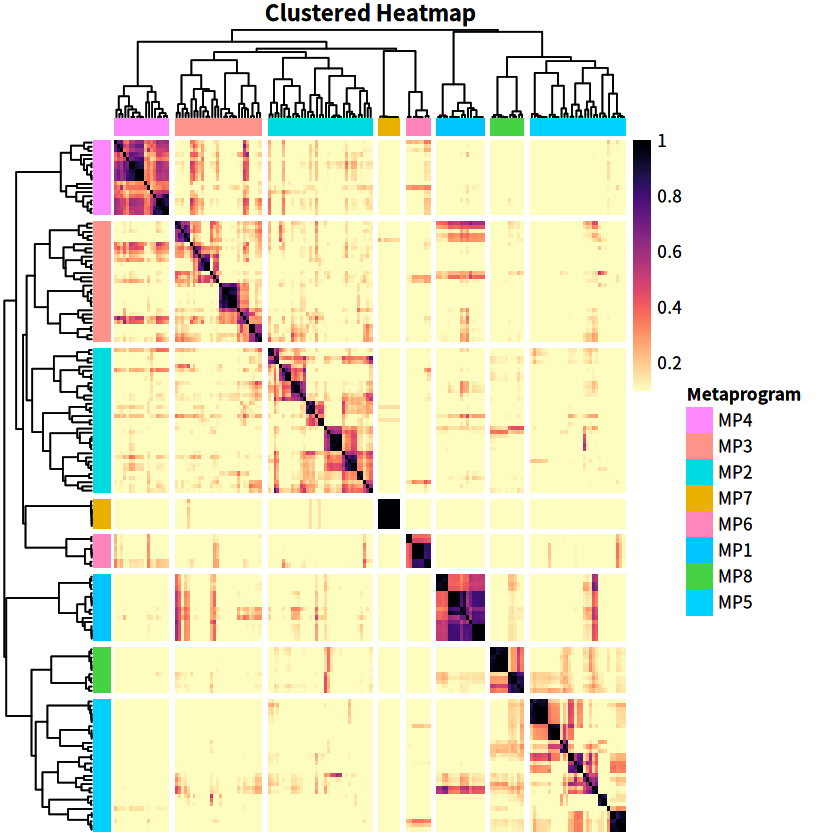

In [29]:
geneNMF.programs.WOtreat <- multiNMF(seu.WOtreat, assay="originalexp", k=4:9, min.exp = 0.05)
geneNMF.metaprograms.WOtreat  <- getMetaPrograms(geneNMF.programs.WOtreat,
                                        metric = "cosine",
                                        weight.explained = 0.8,
                                        nMP=8,
                                        min.confidence = 0.7
                                        )
ph <- plotMetaPrograms(geneNMF.metaprograms.WOtreat,
                       similarity.cutoff = c(0.1,1))
ph

In [30]:
svg(filename = "figures/WOtreatGeneset.svg")
ph
dev.off()

pdf 
  2

In [31]:
geneNMF.metaprograms.WOtreat$metaprograms.metrics

,sampleCoverage,silhouette,meanSimilarity,numberGenes,numberPrograms
,<dbl>,<dbl>,<dbl>,<int>,<chr>
MP1,1.00,0.62294162,0.669,27,16
MP2,1.00,0.08762910,0.224,13,35
MP3,1.00,0.03663575,0.240,19,29
MP4,0.75,0.44145445,0.530,35,18
MP5,0.75,0.09569842,0.240,1,32
MP6,0.50,0.66502452,0.699,41,8
MP7,0.25,0.99073018,0.991,6,7
MP8,0.25,0.53688777,0.597,25,11


In [32]:
top_p.WOtreat <- lapply(geneNMF.metaprograms.WOtreat$metaprograms.genes, function(program) {
  runGSEA(program, universe=rownames(seu), category = "C5")
})

In [33]:
for (i in 1:length(top_p.WOtreat)) {
  fwrite(top_p.WOtreat[[i]], file = paste0("figures/WOtreatGeneSet/TableS6-MP", i, ".csv"), col.names = T, append = F, quote = F)
}

In [34]:
lapply(geneNMF.metaprograms.WOtreat$metaprograms.genes, head)

$MP1
[1] "UBE2C" "STMN1" "PTTG1" "TOP2A" "TPX2"  "MKI67"

$MP2
[1] "PLEC"  "FLNB"  "BAG3"  "ERBB2" "PTPRF" "JUN"  

$MP3
[1] "ISG15" "BTG2"  "H2AZ1" "CKS1B" "FOS"   "IER2" 

$MP4
[1] "NR4A1"    "ATF3"     "BAG3"     "FOSB"     "RND1"     "PPP1R15A"

$MP5
[1] "S100A9"

$MP6
[1] "MGP"   "AREG"  "PLAT"  "NOVA1" "ATF3"  "NR4A1"

$MP7
[1] "SCGB1D2" "SCGB2A2" "TFF3"    "TFF1"    "AZGP1"   "CREB3L1"

$MP8
[1] "HLA-DRB5" "HLA-DRB1" "CLU"      "HLA-DRA"  "HLA-A"    "HLA-C"

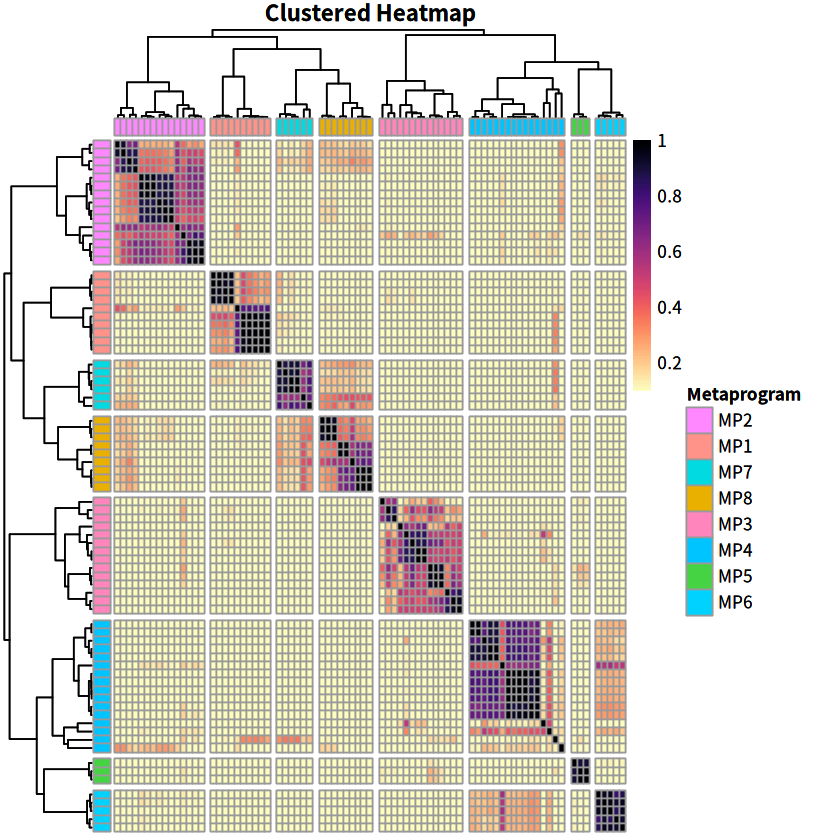

In [102]:
geneNMF.programs.Better <- multiNMF(seu.Better, assay="originalexp", k=4:9, min.exp = 0.05)
geneNMF.metaprograms.Better <- getMetaPrograms(geneNMF.programs.Better,
                                        metric = "cosine",
                                        weight.explained = 0.8,
                                        nMP=8,
                                        min.confidence = 0.7
                                        )
ph <- plotMetaPrograms(geneNMF.metaprograms.Better,
                       similarity.cutoff = c(0.1,1))
ph

In [57]:
svg(filename = "figures/BetterGeneSet.svg",width = 7,height = 6.5)
ph
dev.off()

pdf 
  2

In [58]:
geneNMF.metaprograms.Better$metaprograms.metrics

,sampleCoverage,silhouette,meanSimilarity,numberGenes,numberPrograms
,<dbl>,<dbl>,<dbl>,<int>,<chr>
MP1,1.0,0.5377233,0.599,10,10
MP2,1.0,0.5105766,0.584,33,15
MP3,1.0,0.4340091,0.491,41,14
MP4,1.0,0.3549897,0.527,28,16
MP5,0.5,0.9263751,0.934,38,3
MP6,0.5,0.8867878,0.913,102,5
MP7,0.5,0.6918302,0.783,95,6
MP8,0.5,0.4268373,0.575,51,9


In [59]:
top_p.Better <- lapply(geneNMF.metaprograms.Better$metaprograms.genes, function(program) {
  runGSEA(program, universe=rownames(seu), category = "C5")
})

In [ ]:
top_p.Better <- lapply(geneNMF.metaprograms.Better$metaprograms.genes, function(program) {
  runGSEA(program, universe=rownames(seu), category = "C2")
})

In [106]:
geneNMF.metaprograms.Better$metaprograms.genes

$MP1
 [1] "PIP"      "SERPINA1" "TFPI2"    "PDK4"     "CYP4X1"   "SCGB1B2P"
 [7] "MYBPC1"   "PI15"     "TFF1"     "AGR2"    

$MP2
 [1] "EGR1"       "FOS"        "JUN"        "IER2"       "EGR2"      
 [6] "SOCS3"      "DUSP1"      "JUNB"       "PPP1R10"    "BTG2"      
[11] "FOSB"       "ZFP36"      "CCNL1"      "HES1"       "DDIT3"     
[16] "GATA3"      "ATF3"       "DNAJB1"     "NFKBIZ"     "MAFB"      
[21] "PPP1R15A"   "IRF1"       "GADD45B"    "H2AX"       "SLC38A2"   
[26] "KLF10"      "HEXIM1"     "MAFF"       "TOB1"       "AC011446.2"
[31] "IGFBP5"     "NR4A2"      "RHOB"      

$MP3
 [1] "MMP7"    "GABRP"   "RARRES1" "KRT15"   "SLPI"    "LCN2"    "CCL28"  
 [8] "KRT16"   "KRT6B"   "PIGR"    "KIT"     "LTF"     "LIF"     "PI3"    
[15] "ALDH1A3" "SNORC"   "SCGB2A2" "KRT23"   "CRABP1"  "PROM1"   "TTYH1"  
[22] "S100A9"  "PPP1R1B" "SLC34A2" "KRT14"   "CHI3L2"  "FGFBP1"  "TNFAIP2"
[29] "EMP1"    "MYEOV"   "SLC5A1"  "CXCL3"   "KRT17"   "PDE4B"   "PKP1"   
[36] "ARRDC2"  "DUSP1"   "JUN"     "FOLR1"   "NDRG2"   "LY6D"   

$MP4
 [1] "TAGLN"    "CXCL14"   "ACTA2"    "MYH11"    "CNN1"     "ACTG2"   
 [7] "MYL9"     "MYLK"     "TPM2"     "SYT8"     "POSTN"    "ECRG4"   
[13] "PPP1R14A" "KCNMB1"   "KRT17"    "A2M"      "KRT14"    "MIR205HG"
[19] "COL17A1"  "TGFB1I1"  "LMOD1"    "PDLIM7"   "NEXN"     "SNCG"    
[25] "PCSK7"    "IL17B"    "TNC"      "EFEMP1"  

$MP5
 [1] "AQP5"     "MELTF"    "PRR4"     "TESC"     "SLC26A2"  "TMEM213" 
 [7] "ATP2A3"   "ZG16B"    "IGFBP7"   "ATP6V0A4" "NCALD"    "SLC12A2" 
[13] "SNORC"    "FRZB"     "SLC31A2"  "STK39"    "LTF"      "STAC2"   
[19] "KCNN4"    "PLA2R1"   "S100A1"   "PIP"      "PPP1R1B"  "ROCR"    
[25] "PADI2"    "MRAS"     "PDK3"     "FOS"      "PLEKHB1"  "ACTR3B"  
[31] "FMO5"     "SCGB2A2"  "KRT15"    "SCGB2A1"  "CYP4X1"   "IER2"    
[37] "MYBPC1"   "SLC34A2" 

$MP6
  [1] "IGFBP5"     "TESC"       "COL14A1"    "WIF1"       "ADGRD2"    
  [6] "SNX22"      "COLCA1"     "ACTA2"      "SCN2A"      "NRG2"      
 [11] "TAGLN"      "NES"        "CRTAC1"     "MYL9"       "CST3"      
 [16] "NKAIN3"     "NRG1"       "TPM2"       "HS3ST1"     "SCRG1"     
 [21] "MYLK"       "G0S2"       "BMP5"       "S100B"      "EGR1"      
 [26] "ECRG4"      "CPE"        "SEMA6D"     "NTRK2"      "SFRP1"     
 [31] "C1QL1"      "AC097713.1" "PPP1R14A"   "APOE"       "TNNT1"     
 [36] "COL9A2"     "SPON1"      "CA2"        "RBMS3"      "CDO1"      
 [41] "B4GAT1"     "UBE2S"      "TUBB2B"     "PSAT1"      "S100A1"    
 [46] "TMEM163"    "RARRES2"    "CD164L2"    "A2M"        "LUZP2"     
 [51] "KCNMB1"     "JUNB"       "ADM"        "COL9A3"     "CAMK2B"    
 [56] "TF"         "SOX10"      "CCNL1"      "ITGBL1"     "HAP1"      
 [61] "MATN2"      "SNHG12"     "MIR205HG"   "THSD4"      "NDRG2"     
 [66] "MAFB"       "LINC02607"  "LZTS1"      "ITM2A"      "PDGFA"     
 [71] "GRP"        "FXYD6"      "CDKN1C"     "CDKN1A"     "MT1X"      
 [76] "IL17B"      "TGFB1I1"    "FOS"        "PCSK7"      "JUN"       
 [81] "BMP7"       "PDLIM7"     "MIR100HG"   "DUSP1"      "SNAI2"     
 [86] "EDN3"       "IER2"       "DDIT3"      "AC022034.1" "SFRP2"     
 [91] "KCNQ1OT1"   "GPRC5B"     "H2AX"       "PLAU"       "ANGPTL2"   
 [96] "POU3F3"     "CYP1B1"     "SPP1"       "GLT8D2"     "SYNM"      
[101] "GPX2"       "NEXN"      

$MP7
 [1] "TFPI"       "SYTL2"      "SLC7A2"     "C3orf52"    "TCIM"      
 [6] "PDK4"       "TFF1"       "TNFRSF11B"  "PIP"        "EGLN3"     
[11] "TMC5"       "PHLDB2"     "ANKRD30A"   "TNFAIP8"    "FAM107B"   
[16] "C15orf48"   "AREG"       "RAB11FIP1"  "LRP2"       "VSIG10L2"  
[21] "PTHLH"      "GRAMD4"     "STC2"       "ITGAV"      "CDR2"      
[26] "DAPL1"      "AK5"        "UCP2"       "DNMBP"      "PLAT"      
[31] "DCLK1"      "CMAHP"      "ADAM10"     "EMP1"       "TGM2"      
[36] "KCNK6"      "BAMBI"      "MOCS1"      "MANF"       "PLAUR"     
[41] "MAST4"      "AGR2"       "SDF2L1"     "BATF"       "CREB3L1"   
[46] "ESR1"       "FTO"        "SEMA3C"     "TGFB3"      "MYO1B"   

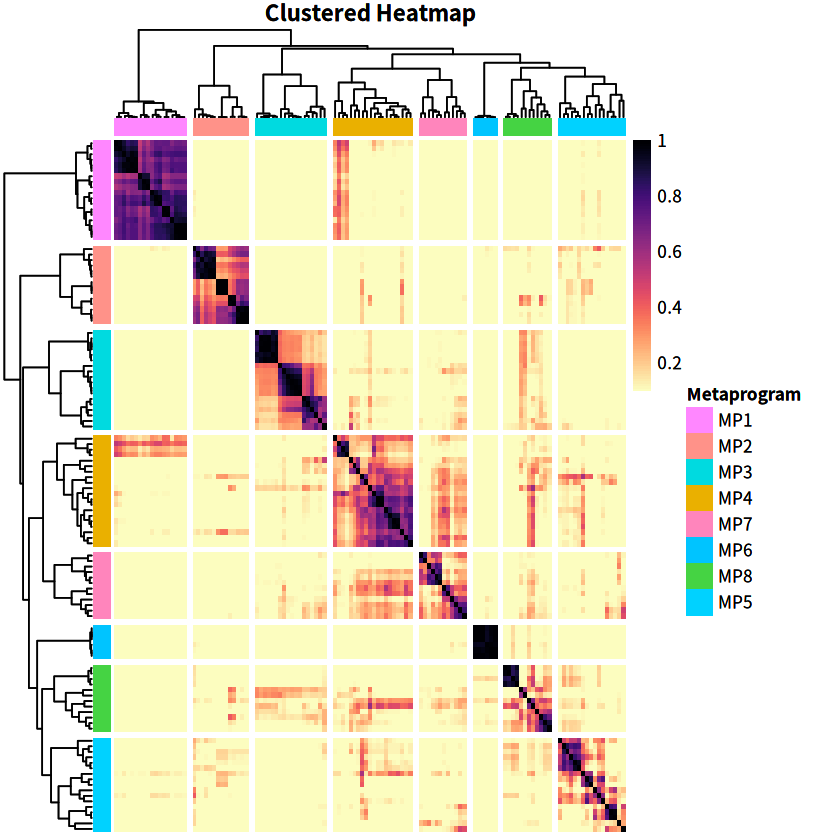

In [62]:
geneNMF.programs.Worse <- multiNMF(seu.Worse, assay="originalexp", k=4:9, min.exp = 0.05)
geneNMF.metaprograms.Worse <- getMetaPrograms(geneNMF.programs.Worse,
                                        metric = "cosine",
                                        weight.explained = 0.8,
                                        nMP=8,
                                        min.confidence = 0.7
                                        )
ph <- plotMetaPrograms(geneNMF.metaprograms.Worse,
                       similarity.cutoff = c(0.1,1))
ph

In [63]:
svg(filename = "figures/WorseGeneSet.svg",width = 7,height = 6.5)
ph
dev.off()

pdf 
  2

In [64]:
geneNMF.metaprograms.Worse$metaprograms.metrics

,sampleCoverage,silhouette,meanSimilarity,numberGenes,numberPrograms
,<dbl>,<dbl>,<dbl>,<int>,<chr>
MP1,1.0000000,0.7416386,0.769,38,18
MP2,1.0000000,0.5283005,0.575,17,14
MP3,1.0000000,0.3896853,0.466,18,18
MP4,1.0000000,0.2749503,0.450,26,20
MP5,0.6666667,0.1777551,0.289,20,17
MP6,0.3333333,0.9763316,0.978,14,6
MP7,0.3333333,0.2255890,0.378,55,12
MP8,0.3333333,0.1958684,0.346,22,12


In [ ]:
top_p.Worse <- lapply(geneNMF.metaprograms.Worse$metaprograms.genes, function(program) {
  runGSEA(program, universe=rownames(seu), category = "C5")
})


In [85]:
geneNMF.metaprograms.Worse$metaprograms.genes

$MP1
 [1] "ACTA2"    "TPM2"     "TAGLN"    "MYLK"     "ECRG4"    "CNN1"    
 [7] "APOE"     "MYL9"     "DKK3"     "KRT14"    "COL17A1"  "PPP1R14A"
[13] "SYT8"     "MYH11"    "CXCL14"   "SPARCL1"  "A2M"      "TP63"    
[19] "TGFB1I1"  "LAMB3"    "DST"      "LTBP2"    "MATN2"    "TSHZ2"   
[25] "MIR205HG" "TNS4"     "FGF1"     "GAS6"     "MSRB3"    "SNCG"    
[31] "ADAMTS5"  "KLHL13"   "HTRA1"    "PDLIM7"   "CAVIN1"   "PDGFA"   
[37] "OSR1"     "EDIL3"   

$MP2
 [1] "KRT15"   "KRT23"   "CCL28"   "LTF"     "SLPI"    "KRT81"   "KIT"    
 [8] "PIGR"    "MGP"     "NDRG2"   "SCGB2A2" "EHF"     "RARRES1" "RGS2"   
[15] "KLK5"    "SORBS2"  "PTN"    

$MP3
 [1] "TFF1"     "TFF3"     "PLAT"     "HSPB8"    "DCDC2"    "ANKRD30A"
 [7] "AFF3"     "C15orf48" "BATF"     "TCIM"     "PIP"      "MIDEAS"  
[13] "ACADSB"   "ESR1"     "TM4SF1"   "AZGP1"    "ZFP36"    "SLC39A6" 

$MP4
 [1] "FOS"      "EGR1"     "ZFP36"    "IER2"     "JUN"      "JUNB"    
 [7] "SOCS3"    "DUSP1"    "FOSB"     "DNAJB1"   "GADD45B"  "HES1"    
[13] "KLF10"    "CCNL1"    "SERTAD1"  "EGR2"     "IER3"     "CSRNP1"  
[19] "PPP1R15A" "ATF3"     "BTG2"     "DUSP2"    "H2AX"     "TIPARP"  
[25] "CLK1"     "SNHG12"  

$MP5
 [1] "CD74"     "HLA-DRA"  "PSMB9"    "HLA-DRB1" "WARS1"    "TAP1"    
 [7] "LAP3"     "HLA-DPA1" "HLA-DQB1" "TYMP"     "EGR1"     "IFITM1"  
[13] "UBE2L6"   "CHI3L1"   "C1S"      "ZFP36"    "HLA-DMA"  "IMPA2"   
[19] "PCNA"     "CTXN1"   

$MP6
 [1] "APOD"    "MUCL1"   "ALDH3B2" "CXCL17"  "SPINK8"  "ALOX15B" "DHRS2"  
 [8] "SORD"    "AQP3"    "FABP7"   "ACP5"    "SRD5A1"  "FKBP5"   "SLC26A3"

$MP7
 [1] "NPPC"       "PEG10"      "ZFP36"      "IGFBP5"     "ATF3"      
 [6] "IER2"       "JUN"        "FN1"        "DUSP1"      "TRIB1"     
[11] "PIP"        "DNAJB1"     "AC093001.1" "NR4A1"      "PPP1R15A"  
[16] "DUSP4"      "JUNB"       "ISG15"      "RND1"       "TRPS1"     
[21] "BBC3"       "DNAJC1"     "STC2"       "MGST1"      "MYLK"      
[26] "RHOB"       "BTG2"       "SRD5A1"     "BMI1"       "MIR205HG"  
[31] "TIPARP"     "SEMA3C"     "TMSB4X"     "PDGFA"      "SCD"       
[36] "ACP5"       "TCIM"       "SLC7A5"     "FLNA"       "ABRACL"    
[41] "TNS4"       "PARD6B"     "FASN"       "HSPA1A"     "HSPA1B"    
[46] "ALCAM"      "CAMK2N1"    "DST"        "ZNF486"     "AFF3"      
[51] "AC011446.2" "MT1G"       "RNF19A"     "FAM107B"    "ST8SIA6"   

$MP8
 [1] "S100P"     "DNAJA4"    "TMEM176A"  "DHRS2"     "C2CD4B"    "MGST1"    
 [7] "METRN"     "SCGB2A2"   "TMEM176B"  "APOD"      "IDH3A"     "GINS2"    
[13] "PPFIA1"    "ETFRF1"    "AGR2"      "MDM2"      "FXYD3"     "RAB11FIP1"
[19] "CCND1"     "KRT19"     "CLU"       "ZNF703"

#### 看样本在不同基因集的表达活性

In [44]:
seu.After <- subset(seu, subset = batch %in% c("11T", "12T", "13T" , "16T", "19T"))

Warning message:
“The `slot` argument of `FetchData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”


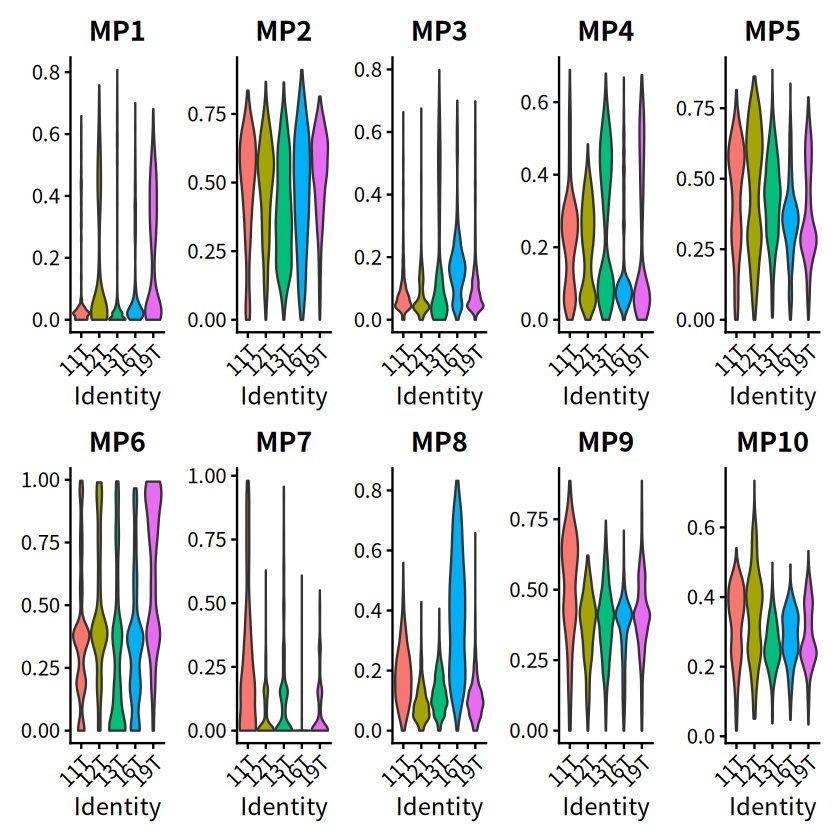

In [45]:
mp.genes <- geneNMF.metaprograms.After$metaprograms.genes
seu.After <- AddModuleScore_UCell(seu.After, features = mp.genes, ncores=4, name = "")
VlnPlot(seu.After, features=names(mp.genes), group.by = "batch",
        pt.size = 0, ncol=5)

In [46]:
library(dplyr)

# 提取模块得分和样本分组信息
module_data <- seu.After@meta.data %>%
  select(all_of(names(mp.genes)), batch)

# 按批次分组并计算中位数
median_scores <- module_data %>%
  group_by(batch) %>%
  summarise(across(all_of(names(mp.genes)), median, na.rm = TRUE))

# 转换为矩阵格式
mp_medians <- as.matrix(median_scores[, -1])
rownames(mp_medians) <- median_scores$batch

# 查看结果
print(mp_medians)


Warning message:
“There was 1 warning in `summarise()`.
ℹ In argument: `across(all_of(names(mp.genes)), median, na.rm = TRUE)`.
ℹ In group 1: `batch = 11T`.
Caused by warning:
! The `...` argument of `across()` is deprecated as of dplyr 1.1.0.
Supply arguments directly to `.fns` through an anonymous function instead.

  # Previously
  across(a:b, mean, na.rm = TRUE)

  # Now
  across(a:b, \(x) mean(x, na.rm = TRUE))”


           MP1       MP2        MP3        MP4       MP5       MP6        MP7
11T 0.02255807 0.5295600 0.06628852 0.22823133 0.4773529 0.3678023 0.16549727
12T 0.02301569 0.5112040 0.04193277 0.21187878 0.4878011 0.3953908 0.00000000
13T 0.02091986 0.3859631 0.07336835 0.30731574 0.4350070 0.1940548 0.08895757
16T 0.03382557 0.4803611 0.16032213 0.08267037 0.3502031 0.3371075 0.00000000
19T 0.21550915 0.5516196 0.07719888 0.08168336 0.3182073 0.7023714 0.00000000
           MP8       MP9      MP10
11T 0.17858342 0.5401771 0.3462844
12T 0.07981705 0.3868749 0.3578411
13T 0.11557570 0.3928093 0.2562352
16T 0.38806647 0.3930486 0.2872935
19T 0.09777610 0.4098827 0.2646237


In [47]:
# 计算两组间的中位差值
group1 <- c("13T", "19T")
group2 <- c("11T", "12T", "16T")

group1_median <- colMeans(mp_medians[group1, , drop = FALSE])
group2_median <- colMeans(mp_medians[group2, , drop = FALSE])
median_diff <- abs(group1_median - group2_median)

# 按差异排序并显示前5个模块
top_diff_mp <- names(sort(median_diff, decreasing = TRUE)[1:5])
print(top_diff_mp)


[1] "MP8"  "MP1"  "MP6"  "MP10" "MP5" 


In [48]:
# 假设seu.After$batch中包含你的两组样本标识
mp_names <- names(mp.genes)
results <- list()

for (mp in mp_names) {
  group1 <- subset(seu.After, subset = batch %in% c("13T", "19T"))
  group2 <- subset(seu.After, subset = batch %in% c("11T", "12T", "16T"))
  
  # 提取MP得分
  mp_scores_group1 <- group1@meta.data[[mp]]
  mp_scores_group2 <- group2@meta.data[[mp]]
  
  # 进行Wilcoxon检验
  test_result <- wilcox.test(mp_scores_group1, mp_scores_group2)
  
  # 保存结果
  results[[mp]] <- c(p.value = test_result$p.value, 
                     avg_diff = mean(mp_scores_group1) - mean(mp_scores_group2))
}

# 转换为数据框并按p值排序
results_df <- as.data.frame(do.call(rbind, results))
results_df$adjusted_p <- p.adjust(results_df$p.value, method = "fdr")
results_df <- results_df[order(results_df$adjusted_p), ]

# 显示差异显著的MP (FDR < 0.05)
significant_mp <- results_df[results_df$adjusted_p < 0.05, ]
print(significant_mp)


          p.value    avg_diff   adjusted_p
MP10 4.931877e-79 -0.05138675 4.931877e-78
MP8  1.836335e-64 -0.09088248 9.181676e-64
MP4  3.230381e-30  0.07076006 1.076794e-29
MP2  3.096907e-11 -0.03133516 7.742267e-11
MP7  9.399445e-09  0.01090353 1.879889e-08
MP9  8.396142e-04 -0.01363515 1.399357e-03
MP1  3.451552e-03  0.02215169 4.930788e-03
MP5  2.323892e-02 -0.01023829 2.904865e-02


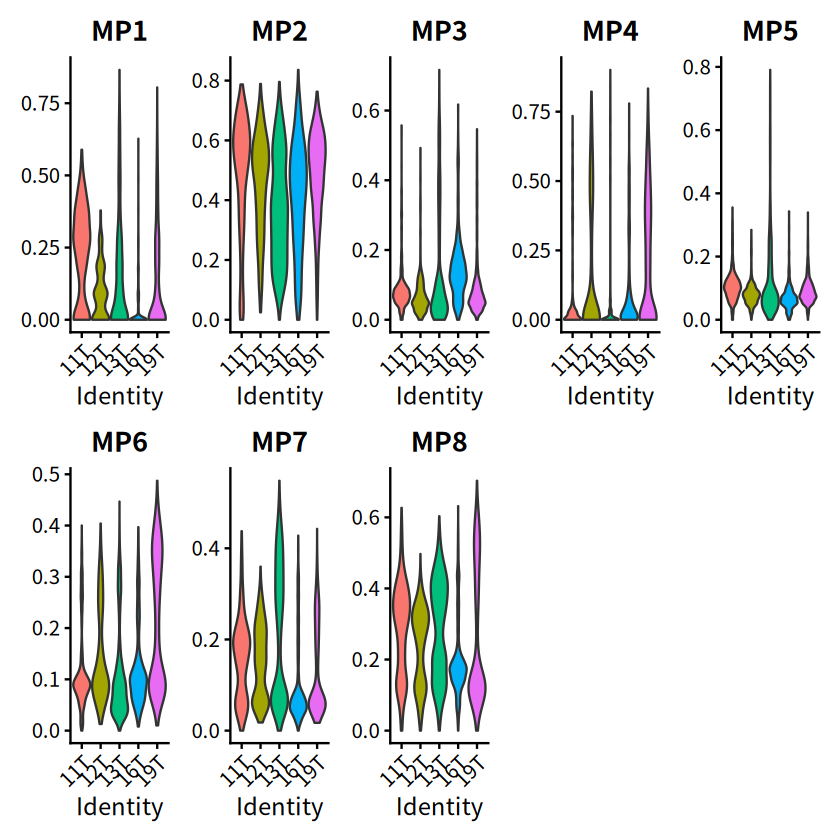

In [67]:
mp.genes <- geneNMF.metaprograms.Better$metaprograms.genes
seu.After <- AddModuleScore_UCell(seu.After, features = mp.genes, ncores=4, name = "")
VlnPlot(seu.After, features=names(mp.genes), group.by = "batch",
        pt.size = 0, ncol=5)

In [70]:
mp_names <- names(mp.genes)
results <- list()

for (mp in mp_names) {
  group1 <- subset(seu.After, subset = batch %in% c("13T", "19T"))
  group2 <- subset(seu.After, subset = batch %in% c("11T", "12T", "16T"))
  
  # 提取MP得分
  mp_scores_group1 <- group1@meta.data[[mp]]
  mp_scores_group2 <- group2@meta.data[[mp]]
  
  # 进行Wilcoxon检验
  test_result <- wilcox.test(mp_scores_group1, mp_scores_group2)
  
  # 保存结果
  results[[mp]] <- c(p.value = test_result$p.value, 
                     avg_diff = mean(mp_scores_group1) - mean(mp_scores_group2))
}

# 转换为数据框并按p值排序
results_df <- as.data.frame(do.call(rbind, results))
results_df$adjusted_p <- p.adjust(results_df$p.value, method = "fdr")
results_df <- results_df[order(results_df$adjusted_p), ]

# 显示差异显著的MP (FDR < 0.05)
significant_mp <- results_df[results_df$adjusted_p < 0.05, ]
print(significant_mp)


         p.value    avg_diff   adjusted_p
MP7 6.981682e-31  0.04957506 5.585346e-30
MP2 8.755526e-21 -0.04224162 3.502210e-20
MP8 1.136532e-15  0.03791484 3.030751e-15
MP3 7.634325e-08  0.02631404 1.526865e-07
MP5 4.622167e-05  0.02816597 7.395467e-05
MP1 8.679809e-04  0.03169607 1.157308e-03


In [ ]:
# 提取模块得分和样本分组信息
module_data <- seu.After@meta.data %>%
  select(all_of(names(mp.genes)), batch)

# 按批次分组并计算中位数
median_scores <- module_data %>%
  group_by(batch) %>%
  summarise(across(all_of(names(mp.genes)), median, na.rm = TRUE))

# 转换为矩阵格式
mp_medians <- as.matrix(median_scores[, -1])
rownames(mp_medians) <- median_scores$batch

# 查看结果
print(mp_medians)


           MP1       MP2        MP3        MP4        MP5        MP6        MP7
11T 0.26323185 0.5399681 0.07282442 0.01928163 0.10099717 0.09064482 0.16598521
12T 0.09073269 0.4895278 0.05394218 0.00000000 0.07746316 0.10546576 0.15061983
13T 0.09633657 0.3654805 0.06400172 0.00000000 0.07941396 0.07986457 0.22365884
16T 0.00000000 0.4351182 0.13121094 0.03310574 0.06435415 0.09987512 0.06489053
19T 0.04016393 0.5071926 0.06491284 0.16646632 0.08438205 0.19346247 0.07419168
          MP8
11T 0.3122822
12T 0.2666015
13T 0.2997745
16T 0.1721506
19T 0.1511493


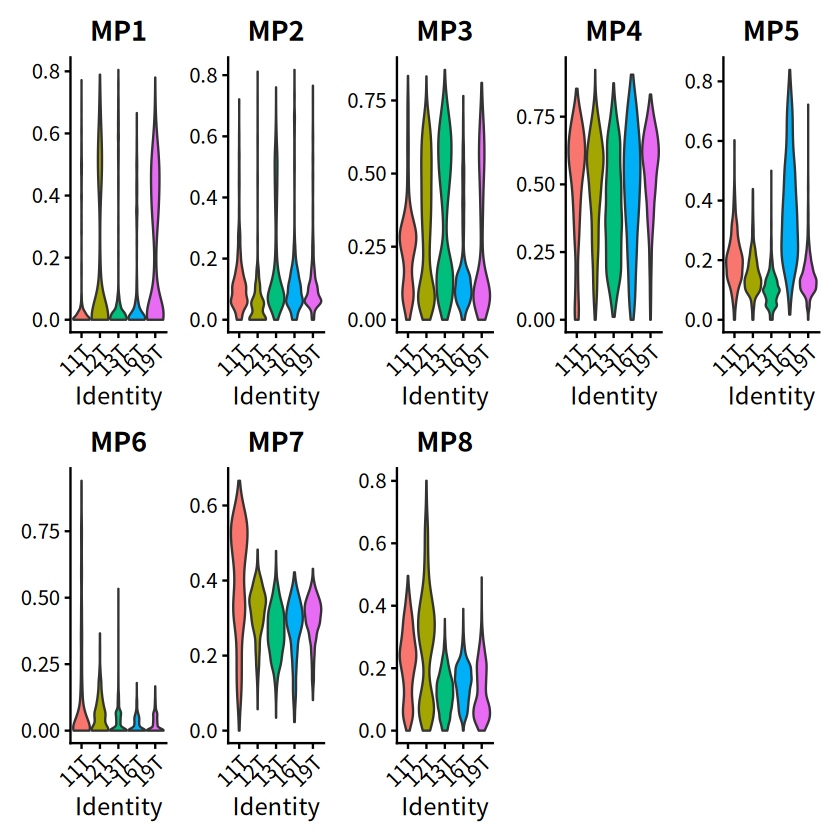

In [71]:
mp.genes <- geneNMF.metaprograms.Worse$metaprograms.genes
seu.After <- AddModuleScore_UCell(seu.After, features = mp.genes, ncores=4, name = "")
VlnPlot(seu.After, features=names(mp.genes), group.by = "batch",
        pt.size = 0, ncol=5)

In [ ]:
mp_names <- names(mp.genes)
results <- list()

for (mp in mp_names) {
  group1 <- subset(seu.After, subset = batch %in% c("13T", "19T"))
  group2 <- subset(seu.After, subset = batch %in% c("11T", "12T", "16T"))
  
  # 提取MP得分
  mp_scores_group1 <- group1@meta.data[[mp]]
  mp_scores_group2 <- group2@meta.data[[mp]]
  
  # 进行Wilcoxon检验
  test_result <- wilcox.test(mp_scores_group1, mp_scores_group2)
  
  # 保存结果
  results[[mp]] <- c(p.value = test_result$p.value, 
                     avg_diff = mean(mp_scores_group1) - mean(mp_scores_group2))
}

# 转换为数据框并按p值排序
results_df <- as.data.frame(do.call(rbind, results))
results_df$adjusted_p <- p.adjust(results_df$p.value, method = "fdr")
results_df <- results_df[order(results_df$adjusted_p), ]

# 显示差异显著的MP (FDR < 0.05)
significant_mp <- results_df[results_df$adjusted_p < 0.05, ]
print(significant_mp)

          p.value    avg_diff    adjusted_p
MP5 1.046444e-296 -0.11659594 8.371554e-296
MP8 3.632255e-161 -0.09874698 1.452902e-160
MP7  7.053798e-80 -0.05149725  1.881013e-79
MP2  1.700362e-61  0.06287309  3.400724e-61
MP1  2.276125e-26  0.03222774  3.641800e-26
MP6  6.342724e-26 -0.04191425  8.456966e-26
MP3  3.849794e-25  0.07528338  4.399764e-25
MP4  8.637612e-14 -0.03673115  8.637612e-14


In [73]:
# 提取模块得分和样本分组信息
module_data <- seu.After@meta.data %>%
  select(all_of(names(mp.genes)), batch)

# 按批次分组并计算中位数
median_scores <- module_data %>%
  group_by(batch) %>%
  summarise(across(all_of(names(mp.genes)), median, na.rm = TRUE))

# 转换为矩阵格式
mp_medians <- as.matrix(median_scores[, -1])
rownames(mp_medians) <- median_scores$batch

# 查看结果
print(mp_medians)


           MP1        MP2       MP3       MP4       MP5        MP6       MP7
11T 0.01279795 0.10042609 0.2527489 0.5680354 0.1923800 0.03642020 0.4224926
12T 0.01060719 0.04740206 0.3316281 0.5289205 0.1403491 0.05306293 0.3264513
13T 0.02104108 0.10004143 0.3870346 0.4008901 0.0992615 0.01874850 0.2655818
16T 0.01850371 0.09448850 0.1234299 0.5006598 0.3521232 0.01002632 0.2877841
19T 0.24529853 0.08745611 0.1300831 0.5751248 0.1354985 0.01167743 0.3067533
          MP8
11T 0.2304639
12T 0.2968745
13T 0.1201713
16T 0.1563426
19T 0.1098650


#### 用治疗后取样组提取出的基因组预测治疗前取样的评估情况

Better: 1 8 9 15 17
Worse: 2

In [74]:
seu.Before <- subset(seu, subset = batch %in% c("1T", "2T", "8T" , "9T", "15T", "17T"))

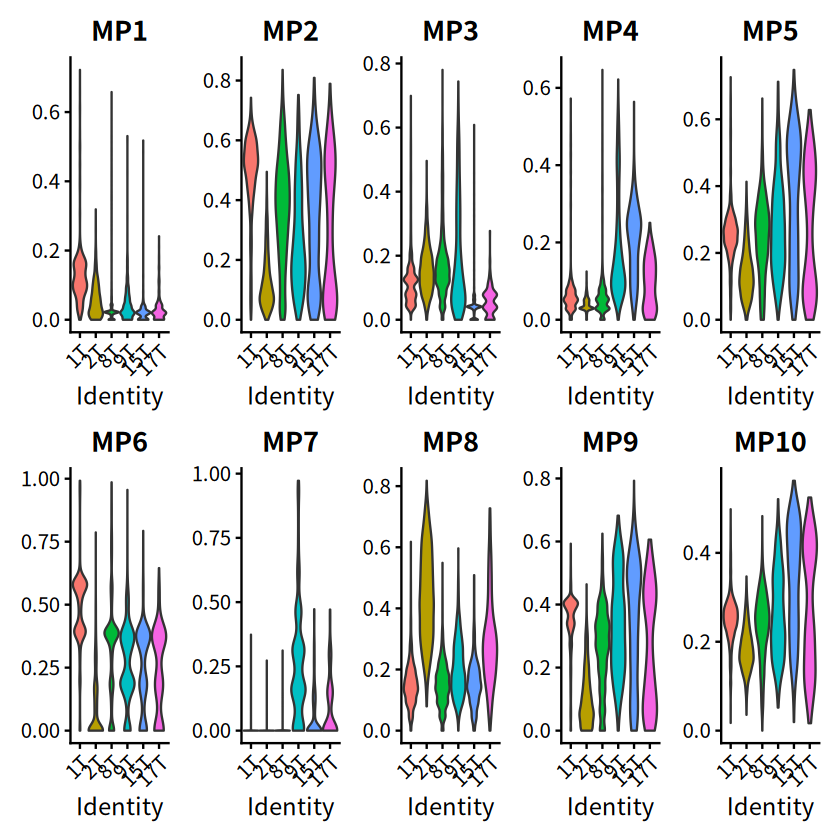

In [ ]:
mp.genes <- geneNMF.metaprograms.After$metaprograms.genes
seu.Before <- AddModuleScore_UCell(seu.Before, features = mp.genes, ncores=4, name = "")
VlnPlot(seu.Before, features=names(mp.genes), group.by = "batch",
        pt.size = 0, ncol=5)
        

In [77]:
# 提取模块得分和样本分组信息
module_data <- seu.Before@meta.data %>%
  select(all_of(names(mp.genes)), batch)

# 按批次分组并计算中位数
median_scores <- module_data %>%
  group_by(batch) %>%
  summarise(across(all_of(names(mp.genes)), median, na.rm = TRUE))

# 转换为矩阵格式
mp_medians <- as.matrix(median_scores[, -1])
rownames(mp_medians) <- median_scores$batch

# 查看结果
print(mp_medians)

           MP1       MP2        MP3        MP4       MP5        MP6       MP7
1T  0.11552453 0.5177464 0.12282213 0.05511854 0.2558053 0.52217769 0.0000000
2T  0.04855791 0.1007198 0.14791317 0.03646464 0.1304902 0.00490982 0.0000000
8T  0.02244655 0.3809590 0.15642857 0.05171114 0.2558894 0.37945892 0.0000000
9T  0.02908014 0.2400615 0.13547619 0.13540819 0.2655602 0.26108884 0.2175354
15T 0.02003538 0.3614536 0.04103641 0.21466124 0.3931863 0.28994656 0.0000000
17T 0.02077373 0.2887728 0.04983193 0.09483186 0.2880392 0.24054776 0.0000000
          MP8       MP9      MP10
1T  0.1462991 0.3751496 0.2529756
2T  0.4335264 0.0839196 0.1784866
8T  0.1492111 0.2763939 0.2438888
9T  0.1860524 0.3282603 0.2518957
15T 0.1488167 0.3776382 0.3584251
17T 0.2722726 0.2357980 0.2677560


In [78]:
mp_names <- names(mp.genes)
results <- list()

for (mp in mp_names) {
  group1 <- subset(seu.Before, subset = batch %in% c("1T", "8T", "9T", "15T", "17T"))
  group2 <- subset(seu.Before, subset = batch %in% c("2T"))
  
  # 提取MP得分
  mp_scores_group1 <- group1@meta.data[[mp]]
  mp_scores_group2 <- group2@meta.data[[mp]]
  
  # 进行Wilcoxon检验
  test_result <- wilcox.test(mp_scores_group1, mp_scores_group2)
  
  # 保存结果
  results[[mp]] <- c(p.value = test_result$p.value, 
                     avg_diff = mean(mp_scores_group1) - mean(mp_scores_group2))
}

# 转换为数据框并按p值排序
results_df <- as.data.frame(do.call(rbind, results))
results_df$adjusted_p <- p.adjust(results_df$p.value, method = "fdr")
results_df <- results_df[order(results_df$adjusted_p), ]

# 显示差异显著的MP (FDR < 0.05)
significant_mp <- results_df[results_df$adjusted_p < 0.05, ]
print(significant_mp)

           p.value      avg_diff    adjusted_p
MP2   0.000000e+00  0.2576701532  0.000000e+00
MP5   0.000000e+00  0.1206103150  0.000000e+00
MP6   0.000000e+00  0.2621661534  0.000000e+00
MP8   0.000000e+00 -0.2785250779  0.000000e+00
MP9   0.000000e+00  0.1915252133  0.000000e+00
MP10  0.000000e+00  0.0668062812  0.000000e+00
MP4  4.952153e-208  0.0477923412 7.074505e-208
MP7  2.136994e-100  0.0437904323 2.671243e-100
MP3   1.467117e-18 -0.0006530992  1.630130e-18
MP1   2.881705e-10  0.0122242693  2.881705e-10


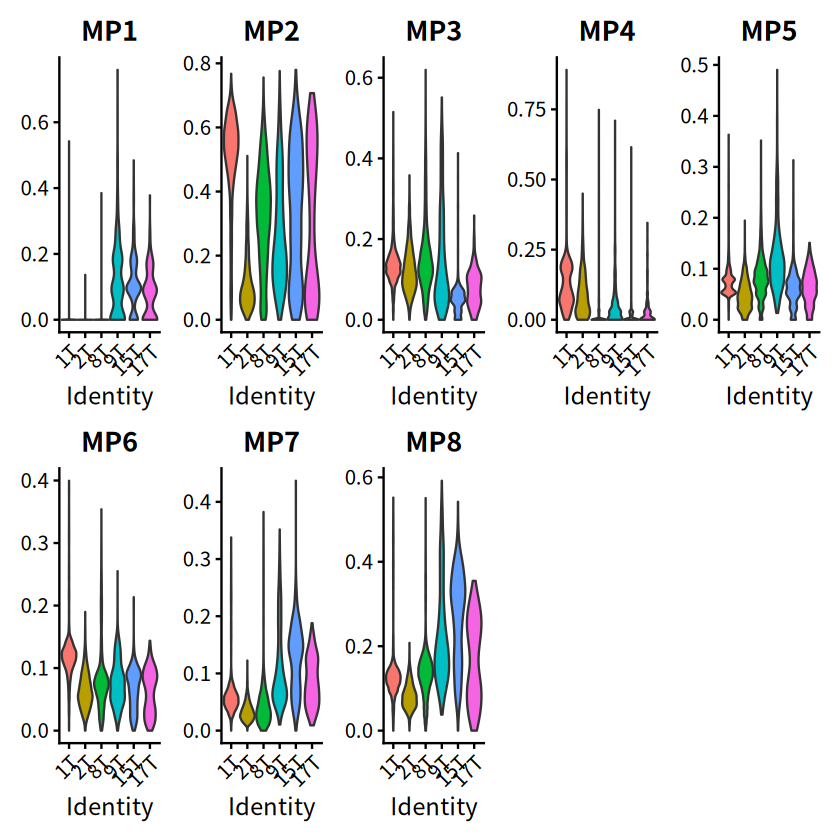

In [79]:
mp.genes <- geneNMF.metaprograms.Better$metaprograms.genes
seu.Before <- AddModuleScore_UCell(seu.Before, features = mp.genes, ncores=4, name = "")
VlnPlot(seu.Before, features=names(mp.genes), group.by = "batch",
        pt.size = 0, ncol=5)

In [81]:
# 提取模块得分和样本分组信息
module_data <- seu.Before@meta.data %>%
  select(all_of(names(mp.genes)), batch)

# 按批次分组并计算中位数
median_scores <- module_data %>%
  group_by(batch) %>%
  summarise(across(all_of(names(mp.genes)), median, na.rm = TRUE))

# 转换为矩阵格式
mp_medians <- as.matrix(median_scores[, -1])
rownames(mp_medians) <- median_scores$batch

# 查看结果
print(mp_medians)

           MP1        MP2        MP3        MP4        MP5        MP6
1T  0.00000000 0.53782260 0.13277346 0.10636149 0.07564123 0.11837804
2T  0.00000000 0.08974438 0.11348719 0.07380872 0.04561048 0.06033287
8T  0.00000000 0.33488118 0.13600571 0.00000000 0.07958282 0.07311993
9T  0.09931415 0.22701220 0.10514685 0.03038900 0.10908032 0.07305224
15T 0.09924724 0.35091134 0.04873926 0.00000000 0.05947493 0.07090330
17T 0.08464369 0.29263982 0.07546299 0.01262201 0.06434526 0.06650896
           MP7        MP8
1T  0.05501124 0.12258893
2T  0.03064376 0.07888366
8T  0.03657025 0.13475071
9T  0.08452588 0.19290247
15T 0.13386074 0.29011360
17T 0.08142671 0.17047117


In [82]:
mp_names <- names(mp.genes)
results <- list()

for (mp in mp_names) {
  group1 <- subset(seu.Before, subset = batch %in% c("1T", "8T", "9T", "15T", "17T"))
  group2 <- subset(seu.Before, subset = batch %in% c("2T"))
  
  # 提取MP得分
  mp_scores_group1 <- group1@meta.data[[mp]]
  mp_scores_group2 <- group2@meta.data[[mp]]
  
  # 进行Wilcoxon检验
  test_result <- wilcox.test(mp_scores_group1, mp_scores_group2)
  
  # 保存结果
  results[[mp]] <- c(p.value = test_result$p.value, 
                     avg_diff = mean(mp_scores_group1) - mean(mp_scores_group2))
}

# 转换为数据框并按p值排序
results_df <- as.data.frame(do.call(rbind, results))
results_df$adjusted_p <- p.adjust(results_df$p.value, method = "fdr")
results_df <- results_df[order(results_df$adjusted_p), ]

# 显示差异显著的MP (FDR < 0.05)
significant_mp <- results_df[results_df$adjusted_p < 0.05, ]
print(significant_mp)

          p.value    avg_diff    adjusted_p
MP2  0.000000e+00  0.25054754  0.000000e+00
MP5  0.000000e+00  0.03601911  0.000000e+00
MP8  0.000000e+00  0.07173768  0.000000e+00
MP7 1.248720e-216  0.03060847 2.497440e-216
MP4 4.665842e-177 -0.02120807 7.465346e-177
MP6 1.830504e-138  0.02448615 2.440671e-138
MP1  5.816450e-94  0.02892885  6.647371e-94
MP3  6.740368e-12  0.01749453  6.740368e-12


In [108]:
mp.genes <- geneNMF.metaprograms.Worse$metaprograms.genes
seu.Before <- AddModuleScore_UCell(seu.Before, features = mp.genes, ncores=4, name = "")
VlnPlot(seu.Before, features=names(mp.genes), group.by = "batch",
        pt.size = 0, ncol=5)

ERROR: Error in UseMethod(generic = "DefaultAssay", object = object): "DefaultAssay"没有适用于"list"目标对象的方法


In [113]:
# 1. 读取 CSV 为矩阵，行为细胞名，列为基因
residual_mat <- read.csv("residual_matrix.csv", row.names = 1)
residual_mat <- as.matrix(residual_mat)


In [114]:
dim(residual_mat)             # 原始：cells x genes
dim(t(residual_mat))          # 转置后：genes x cells
all(colnames(t(residual_mat)) == colnames(seu))  # TRUE


[1] 38680 39735

[1] 39735 38680

[1] TRUE

In [121]:

# 2. 匹配顺序
# 保证 residual_mat 的行（cell）顺序和 seu 对象一致
residual_mat_use <- residual_mat[colnames(seu), , drop = FALSE]

# 3. 创建新的 assay 并放入 Seurat 对象
seu[["residual"]] <- Seurat::CreateAssayObject(counts = t(residual_mat))  # 注意要转置

# 4. 设置默认 assay 并继续后续分析
DefaultAssay(seu) <- "residual"

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


Warning message in eval(predvars, data, env):
“产生了NaNs”
Warning message in hvf.info$variance.expected[not.const] <- 10^fit$fitted:
“被替换的项目不是替换值长度的倍数”
Warning message in eval(predvars, data, env):
“产生了NaNs”
Warning message in hvf.info$variance.expected[not.const] <- 10^fit$fitted:
“被替换的项目不是替换值长度的倍数”
Warning message in eval(predvars, data, env):
“产生了NaNs”
Warning message in hvf.info$variance.expected[not.const] <- 10^fit$fitted:
“被替换的项目不是替换值长度的倍数”
Warning message in eval(predvars, data, env):
“产生了NaNs”
Warning message in hvf.info$variance.expected[not.const] <- 10^fit$fitted:
“被替换的项目不是替换值长度的倍数”
Warning message in eval(predvars, data, env):
“产生了NaNs”
Warning message in hvf.info$variance.expected[not.const] <- 10^fit$fitted:
“被替换的项目不是替换值长度的倍数”
Dropped 1 empty meta-programs



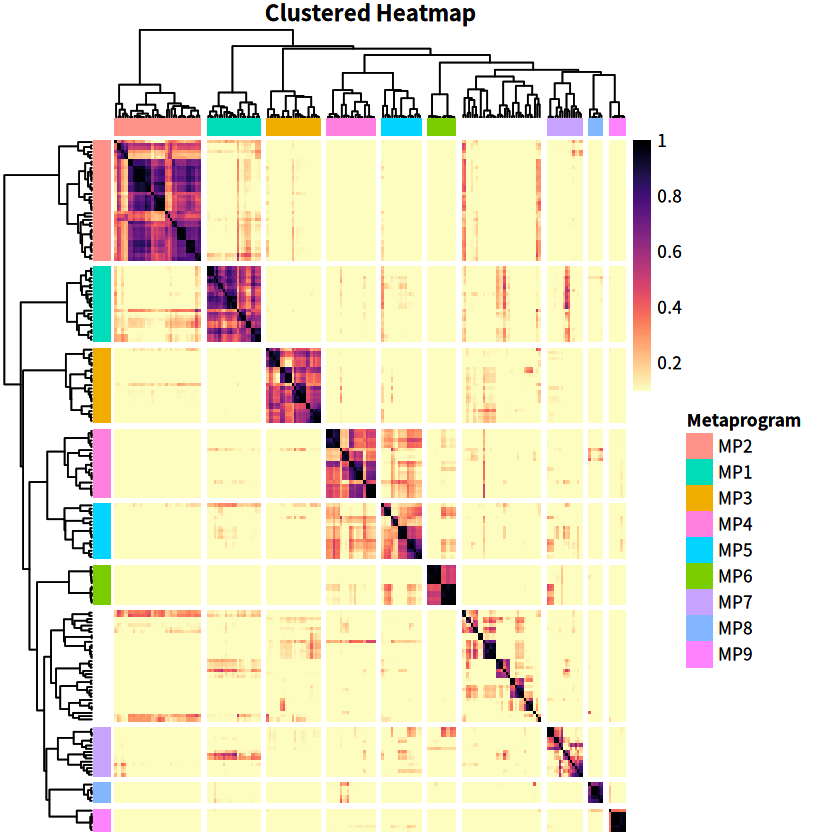

In [135]:
geneNMF.programs.After <- multiNMF(seu.After, assay="residual", k=4:9, min.exp = 0.05)
geneNMF.metaprograms.After <- getMetaPrograms(geneNMF.programs.After,
                                        metric = "cosine",
                                        weight.explained = 0.8,
                                        nMP=10,
                                        min.confidence = 0.7
                                        )
ph <- plotMetaPrograms(geneNMF.metaprograms.After,
                       similarity.cutoff = c(0.1,1))
ph

In [136]:
top_p.After <- lapply(geneNMF.metaprograms.After$metaprograms.genes, function(program) {
  runGSEA(program, universe=rownames(seu), category = "C5")
})


In [139]:
geneNMF.metaprograms.After$metaprograms.genes

$MP1
 [1] "JUNB"     "EGR1"     "JUN"      "FOS"      "ZFP36"    "SOCS3"   
 [7] "DNAJB1"   "FOSB"     "CCNL1"    "GADD45B"  "HSPA1B"   "PPP1R15A"
[13] "MCL1"     "MYC"      "SERTAD1"  "DUSP1"    "HSP90AB1" "CSRNP1"  
[19] "EGR2"     "BRD2"     "HSPA1A"   "DDIT3"    "KLF10"    "H2AX"    
[25] "CEBPD"   

$MP2
 [1] "ACTA2"    "TAGLN"    "TPM2"     "MYLK"     "CXCL14"   "MYL9"    
 [7] "CNN1"     "MYH11"    "ECRG4"    "ACTG2"    "SYT8"     "PPP1R14A"
[13] "MATN2"    "KCNMB1"   "MIR205HG" "APOE"     "SPARCL1"  "COL17A1" 
[19] "A2M"      "COL14A1"  "DKK3"     "KRT14"    "TGFB1I1"  "DST"     
[25] "OXTR"     "PDLIM7"   "FLNA"     "EGR1"     "ADAMTS5"  "SNCG"    

$MP3
 [1] "MMP7"    "SLPI"    "RARRES1" "LTF"     "CCL28"   "KRT23"   "LCN2"   
 [8] "MGP"     "KRT6B"   "KRT7"    "PIGR"    "KRT16"   "PLEKHS1" "CHI3L2" 
[15] "CLDN1"   "SCGB2A2" "KLK5"    "KRT14"   "EHF"     "WFDC2"   "NDRG2"  
[22] "SLC6A14" "KRT17"   "FOLR1"  

$MP4
 [1] "TFF3"     "TFF1"     "STC2"     "AGR2"     "SCUBE2"   "AZGP1"   
 [7] "AGR3"     "DCDC2"    "PDK4"     "AREG"     "BATF"     "MGP"     
[13] "PLAT"     "ERBB4"    "CITED1"   "ACADSB"   "SCGB3A1"  "PIP"     
[19] "VSIG10L2" "C16ORF89" "ST8SIA6"  "SERPINA1" "C15ORF48" "RND1"    
[25] "DAPL1"   

$MP5
 [1] "TCIM"      "AREG"      "PDK4"      "TMC5"      "MIDEAS"    "RAB11FIP1"
 [7] "C15ORF48"  "BATF"      "SYTL2"     "GPRC5A"    "BAMBI"     "STC2"     
[13] "TFPI"      "ALAS1"     "PTHLH"     "PLAT"      "MGP"       "SCUBE2"   
[19] "CMAHP"     "ITPKC"     "HSPA5"     "FAM107B"   "CSRNP1"    "SOCS2"    
[25] "HSPD1"     "IRF1"      "HSPA1A"    "PPP1R15A"  "HMGCS2"    "TACSTD2"  
[31] "PPP1R10"   "CREB3L1"   "ACADSB"    "CYTOR"     "ERBB4"     "NTN4"     
[37] "DHCR24"    "PAWR"      "STOM"      "MAFF"     

$MP6
[1] "MUCL1"    "PIP"      "HMGCS2"   "SCGB1B2P" "LTF"     

$MP7
[1] "SCGB2A2"  "PIP"      "SCGB1B2P" "IGFBP5"   "UBC"      "JUND"     "ELF3"    

$MP8
 [1] "IGF1R"      "FAM174B"    "CCT2"       "ARL1"       "CAND1"     
 [6] "DHRS2"      "CHD2"       "MGST1"      "AC093001.1" "TFPI"      
[11] "APOD"       "KRAS"       "MRPS35"     "JUN"        "RAP1B"     
[16] "EGR1"       "UTP20"      "NUP107"     "METRN"      "ETNK1"     
[21] "MGP"        "ARIH1"      "RASSF8.AS1" "FGFR1OP2"   "PKM"       
[26] "SCGB2A2"    "DDC"        "IFI27"      "RAB11FIP1"  "LARP6"     
[31] "SYNM"       "VMP1"       "PPP1R12A"   "KRT7"       "OSBPL8"    
[36] "PAWR"       "NAP1L1"     "ANO1"       "HSP90B1"   

$MP9
 [1] "CPB1"      "TFF1"      "HES4"      "PIP"       "DNAJB1"    "HSPA6"    
 [7] "CLDN4"     "JUNB"      "MGST3"     "ISG15"     "RAB11FIP1" "RASA1"    
[13] "SELENBP1"  "EGR1"      "TM4SF1"    "DMKN"      "GADD45B"   "HES1"     
[19] "NFATC4"    "NR4A1AS"   "GP2"       "KRT18"     "EZR"       "GPRC5A"   
[25] "CCNL1"     "GPATCH2"   "MIDEAS"    "KIAA0040"  "APOD"      "BTG2"     
[31] "EGR2"      "ELF3"      "PLAT"      "CSRNP1"    "TFF3"      "FXYD5"

Warning message in eval(predvars, data, env):
“产生了NaNs”
Warning message in hvf.info$variance.expected[not.const] <- 10^fit$fitted:
“被替换的项目不是替换值长度的倍数”
Warning message in eval(predvars, data, env):
“产生了NaNs”
Warning message in hvf.info$variance.expected[not.const] <- 10^fit$fitted:
“被替换的项目不是替换值长度的倍数”


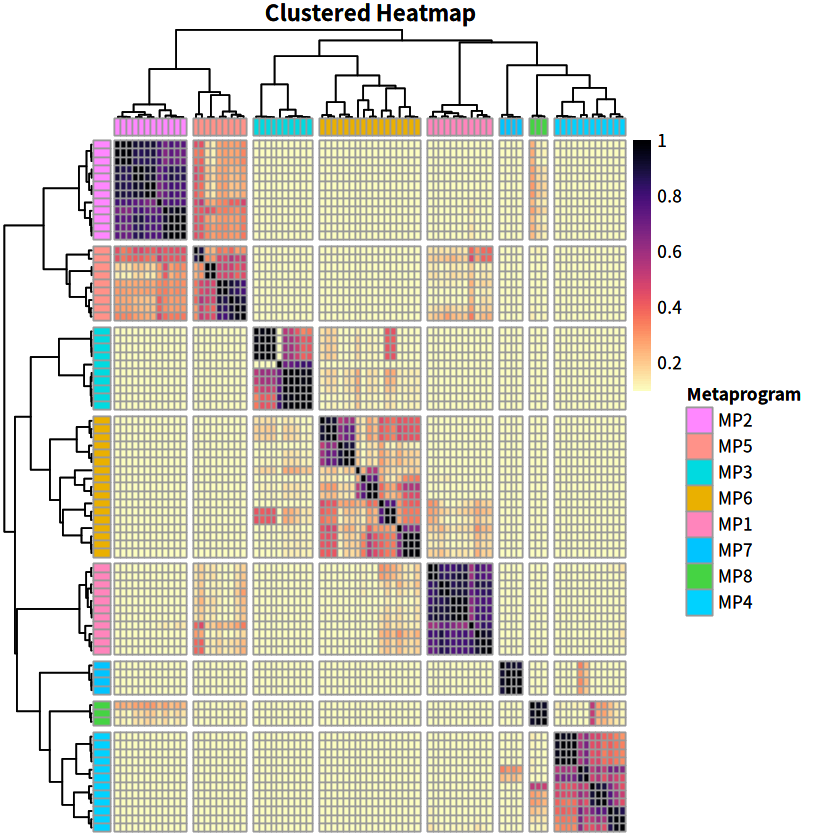

In [138]:
geneNMF.programs.Better <- multiNMF(seu.Better, assay="residual", k=4:9, min.exp = 0.05)
geneNMF.metaprograms.Better <- getMetaPrograms(geneNMF.programs.Better,
                                        metric = "cosine",
                                        weight.explained = 0.8,
                                        nMP=8,
                                        min.confidence = 0.7
                                        )
ph <- plotMetaPrograms(geneNMF.metaprograms.Better,
                       similarity.cutoff = c(0.1,1))
ph

In [140]:
geneNMF.metaprograms.Better$metaprograms.genes

$MP1
 [1] "JUN"      "JUNB"     "EGR1"     "DNAJB1"   "FOS"      "IER2"    
 [7] "ZFP36"    "SOCS3"    "FOSB"     "MCL1"     "CCNL1"    "PPP1R15A"
[13] "HSPA1B"   "PPP1R10"  "EGR2"     "MYC"      "DDIT3"    "UBE2S"   
[19] "SNHG12"   "DNAJA1"   "SERTAD1"  "GADD45B" 

$MP2
 [1] "ACTA2"    "TAGLN"    "CXCL14"   "CNN1"     "ACTG2"    "MYH11"   
 [7] "MYL9"     "MYLK"     "TPM2"     "KCNMB1"   "PPP1R14A" "SYT8"    
[13] "KRT17"    "TGFB1I1"  "KRT14"    "PCSK7"    "FLNA"     "PDLIM7"  
[19] "COL17A1"  "TIMP3"   

$MP3
[1] "PIP"      "MUCL1"    "SERPINA1" "TFPI2"    "PDK4"     "CYP4X1"   "PI15"    

$MP4
 [1] "MMP7"    "SLPI"    "KRT15"   "CCL28"   "KIT"     "PI3"     "ALDH1A3"
 [8] "KRT16"   "PIGR"    "LCN2"    "KRT6B"   "PROM1"   "LTF"     "ASS1"   
[15] "OLFM4"   "CALML5"  "CXCL3"   "CHI3L2"  "KRT14"   "SCGB1D2" "MYEOV"  
[22] "EMP1"    "PDE4B"   "SLC6A14" "KRT17"   "SCGB2A1" "FOLR1"   "SCGB3A1"
[29] "PKP1"    "CX3CL1" 

$MP5
 [1] "WIF1"       "IGFBP5"     "CST3"       "ACTA2"      "APOE"      
 [6] "COLCA1"     "SNX22"      "COL14A1"    "SCN2A"      "EGR1"      
[11] "MYL9"       "TPM2"       "TAGLN"      "JUNB"       "MYLK"      
[16] "GRP"        "CCNL1"      "PPP1R14A"   "HS3ST1"     "FOS"       
[21] "NES"        "CPE"        "ECRG4"      "NDRG2"      "IER2"      
[26] "NRG2"       "S100B"      "GPNMB"      "AC097713.1" "TUBB2B"    
[31] "MXRA8"      "MIR205HG"   "G0S2"       "S100A1"     "B4GAT1"    
[36] "NRG1"       "CDKN1C"     "PPP1R15A"   "DDIT3"      "RBMS3"     
[41] "NTRK2"      "SRSF7"      "PDGFA"      "A2M"        "COL9A2"    
[46] "MATN2"      "EIF5"       "APOC1"      "BRD2"       "MAFB"      
[51] "SRSF3"     

$MP6
 [1] "AREG"     "TCIM"     "SYTL2"    "BATF"     "TFF1"     "PDK4"    
 [7] "TFF3"     "AGR2"     "STC2"     "SCUBE2"   "C15ORF48" "AGR3"    
[13] "AZGP1"    "DAPL1"    "MGP"      "PLAT"     "MIDEAS"   "VSIG10L2"
[19] "DCDC2"    "SUB1"     "RND1"     "ERBB4"    "HSPA5"    "CMAHP"   
[25] "NEK10"    "SLC40A1" 

$MP7
 [1] "AQP5"    "MELTF"   "SLC12A2" "NCALD"   "TESC"    "PLA2R1"  "LTF"    
 [8] "PDK3"    "KCNN4"   "PADI2"   "PDCD4"   "S100A1"  "ROCR"    "MRAS"   
[15] "FRZB"    "PIP"     "SCGB2A1" "STAC2"   "SLPI"    "LCN2"    "GLS"    
[22] "CLDN1"   "ITPR2"   "GCNT2"   "ZFP36"   "CBR3"    "HIF1A"   "SCGB1D2"
[29] "CCDC71L" "DBI"     "PDE5A"   "SOCS3"   "CYP4X1"  "KRT15"   "PIGR"   
[36] "SLC6A14" "NDRG2"   "PROM1"  

$MP8
 [1] "S100A2"   "KRT17"    "CALML3"   "NPC2"     "KRT14"    "TGFBI"   
 [7] "TAGLN"    "KRT15"    "BGN"      "SERPINA1" "S100A11"  "DSC3"    
[13] "MMP7"     "DSG3"     "MXRA8"    "GPNMB"    "APOC1"    "KRT6B"   
[19] "MYL9"     "FOS"      "TNC"      "RBP1"     "APOD"     "SBSPON"  
[25] "SYT8"     "ISLR"     "KRT5"     "MYLK"     "PLPP3"    "APOE"    
[31] "EGR1"     "LCN2"     "KRT7"     "ANKH"     "TIMP1"    "DNAJB1"  
[37] "KCNMB1"   "CCN2"

In [142]:
seu.After <- subset(seu, subset = batch %in% c("11T", "12T", "13T" , "16T", "19T"))

In [144]:
seu.Before <- subset(seu, subset = batch %in% c("1T", "2T", "8T" , "9T", "15T", "17T"))

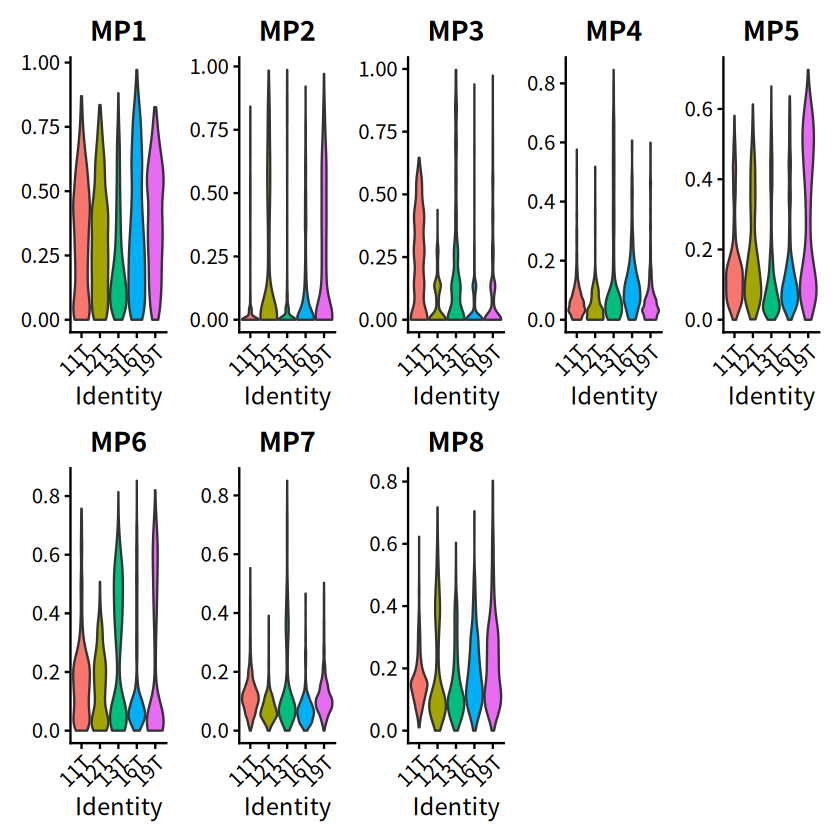

In [146]:
mp.genes <- geneNMF.metaprograms.Better$metaprograms.genes
seu.After <- AddModuleScore_UCell(seu.After, features = mp.genes, ncores=4, name = "")
VlnPlot(seu.After, features=names(mp.genes), group.by = "batch",
        pt.size = 0, ncol=5)

In [149]:
# 提取模块得分和样本分组信息
module_data <- seu.After@meta.data %>%
  select(all_of(names(mp.genes)), batch)

# 按批次分组并计算中位数
median_scores <- module_data %>%
  group_by(batch) %>%
  summarise(across(all_of(names(mp.genes)), median, na.rm = TRUE))

# 转换为矩阵格式
mp_medians <- as.matrix(median_scores[, -1])
rownames(mp_medians) <- median_scores$batch

# 查看结果
print(mp_medians)

          MP1          MP2       MP3        MP4        MP5        MP6
11T 0.3297401 0.0000000000 0.2224026 0.05400247 0.12403225 0.15382028
12T 0.3019666 0.0348439074 0.0000000 0.03340070 0.14034108 0.14620042
13T 0.1715882 0.0005706613 0.1183633 0.06658808 0.07542501 0.28157262
16T 0.3150212 0.0365055388 0.0000000 0.10026945 0.09736744 0.07577169
19T 0.3812105 0.1724068479 0.0000000 0.05058942 0.27156331 0.06828120
           MP7       MP8
11T 0.11093336 0.1479230
12T 0.06981994 0.1081960
13T 0.09059884 0.1133596
16T 0.06711815 0.1646492
19T 0.10327237 0.2034163


In [147]:
mp_names <- names(mp.genes)
results <- list()

for (mp in mp_names) {
  group1 <- subset(seu.After, subset = batch %in% c("13T", "19T"))
  group2 <- subset(seu.After, subset = batch %in% c("11T", "12T", "16T"))
  
  # 提取MP得分
  mp_scores_group1 <- group1@meta.data[[mp]]
  mp_scores_group2 <- group2@meta.data[[mp]]
  
  # 进行Wilcoxon检验
  test_result <- wilcox.test(mp_scores_group1, mp_scores_group2)
  
  # 保存结果
  results[[mp]] <- c(p.value = test_result$p.value, 
                     avg_diff = mean(mp_scores_group1) - mean(mp_scores_group2))
}

# 转换为数据框并按p值排序
results_df <- as.data.frame(do.call(rbind, results))
results_df$adjusted_p <- p.adjust(results_df$p.value, method = "fdr")
results_df <- results_df[order(results_df$adjusted_p), ]

# 显示差异显著的MP (FDR < 0.05)
significant_mp <- results_df[results_df$adjusted_p < 0.05, ]
print(significant_mp)

         p.value     avg_diff   adjusted_p
MP7 5.577187e-39  0.056272882 4.461750e-38
MP6 2.445275e-25  0.100411100 9.781101e-25
MP1 4.502113e-12 -0.042916320 1.200563e-11
MP3 3.867264e-11  0.055645860 7.734527e-11
MP4 5.967371e-06  0.053570502 9.547793e-06
MP5 2.753251e-03  0.021259500 3.671002e-03
MP8 8.051348e-03 -0.006566744 9.201541e-03
MP2 1.553719e-02  0.027733464 1.553719e-02


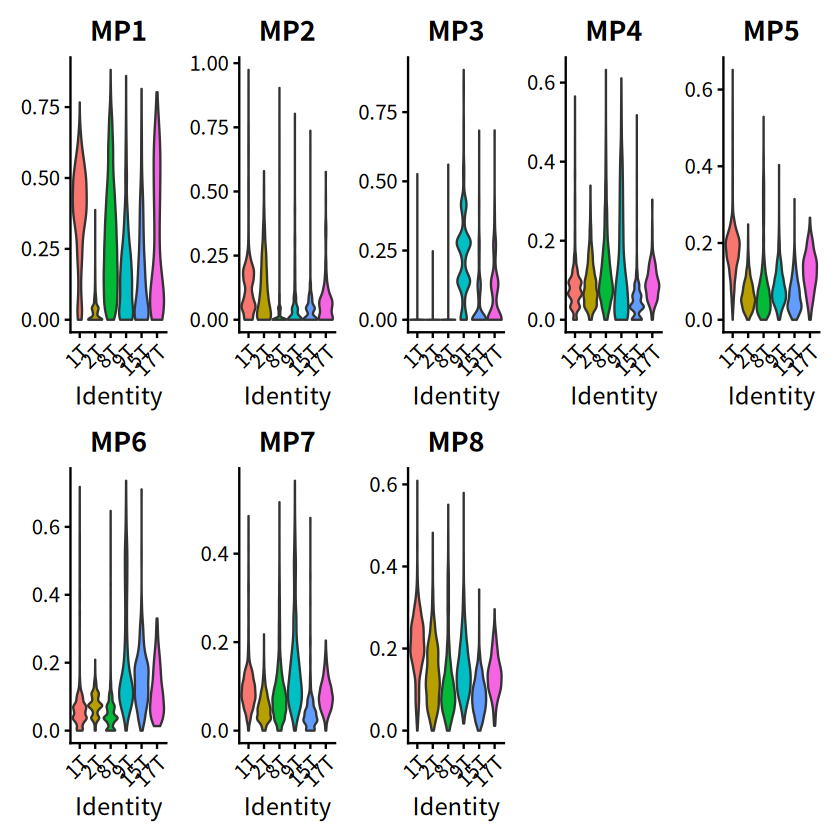

In [145]:
mp.genes <- geneNMF.metaprograms.Better$metaprograms.genes
seu.Before <- AddModuleScore_UCell(seu.Before, features = mp.genes, ncores=4, name = "")
VlnPlot(seu.Before, features=names(mp.genes), group.by = "batch",
        pt.size = 0, ncol=5)
      

In [150]:
# 提取模块得分和样本分组信息
module_data <- seu.Before@meta.data %>%
  select(all_of(names(mp.genes)), batch)

# 按批次分组并计算中位数
median_scores <- module_data %>%
  group_by(batch) %>%
  summarise(across(all_of(names(mp.genes)), median, na.rm = TRUE))

# 转换为矩阵格式
mp_medians <- as.matrix(median_scores[, -1])
rownames(mp_medians) <- median_scores$batch

# 查看结果
print(mp_medians)

           MP1        MP2        MP3        MP4        MP5        MP6
1T  0.40377745 0.10572340 0.00000000 0.07759066 0.18048793 0.05927708
2T  0.02223104 0.09377308 0.00000000 0.08259796 0.06086546 0.07509897
8T  0.25835954 0.00000000 0.00000000 0.10575951 0.06319339 0.04381743
9T  0.14179925 0.02443773 0.24508212 0.08796452 0.07760662 0.13913685
15T 0.11407152 0.03469285 0.00000000 0.03856517 0.05713412 0.14851613
17T 0.20490427 0.05803961 0.04765088 0.08584260 0.12546891 0.10476338
           MP7        MP8
1T  0.08921239 0.20873105
2T  0.04896106 0.13249436
8T  0.07374820 0.09617128
9T  0.11686130 0.14133739
15T 0.03428785 0.08208464
17T 0.07703656 0.13244103


In [148]:
mp_names <- names(mp.genes)
results <- list()

for (mp in mp_names) {
  group1 <- subset(seu.Before, subset = batch %in% c("1T", "8T", "9T", "15T", "17T"))
  group2 <- subset(seu.Before, subset = batch %in% c("2T"))
  
  # 提取MP得分
  mp_scores_group1 <- group1@meta.data[[mp]]
  mp_scores_group2 <- group2@meta.data[[mp]]
  
  # 进行Wilcoxon检验
  test_result <- wilcox.test(mp_scores_group1, mp_scores_group2)
  
  # 保存结果
  results[[mp]] <- c(p.value = test_result$p.value, 
                     avg_diff = mean(mp_scores_group1) - mean(mp_scores_group2))
}

# 转换为数据框并按p值排序
results_df <- as.data.frame(do.call(rbind, results))
results_df$adjusted_p <- p.adjust(results_df$p.value, method = "fdr")
results_df <- results_df[order(results_df$adjusted_p), ]

# 显示差异显著的MP (FDR < 0.05)
significant_mp <- results_df[results_df$adjusted_p < 0.05, ]
print(significant_mp)

          p.value    avg_diff    adjusted_p
MP1  0.000000e+00  0.25887051  0.000000e+00
MP7 1.005594e-191  0.04102574 4.022376e-191
MP2 4.363368e-147 -0.04213735 1.163565e-146
MP5  6.922312e-96  0.04376311  1.384462e-95
MP3  2.999100e-30  0.03040394  4.798560e-30
MP6  2.607256e-29  0.01257372  3.476342e-29
MP4  1.534007e-09  0.02124092  1.753151e-09
